In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ACSE-9')

# Making Predictions

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sat Aug  7 15:56:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    35W / 250W |    865MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

### Data from compression using PCA (43 pod coefficients)

#### Load POD coefficients and PCA compression module

In [ ]:
import joblib

# pca_compress = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/pod_coefficients_full.pkl')

enhanced_data = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/enhanced_data_410.pkl')
pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/pca_compress_410.pkl')
scaler_minmax = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler_minmax_410.pkl')

scaler_std = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_std_410.pkl')
scaler_x = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_x_410.pkl')
scaler_y = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_y_410.pkl')
scaler_z = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_z_410.pkl')
scaler_enhanced = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/CO2_scaler_minmax_410.pkl')

CO2_sensor = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_410.pkl')
C02_sensor_all = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_all.pkl')

### Prepare data for the GAN

In [ ]:
X_train_pca = enhanced_data
print(X_train_pca.shape)
codings_size = X_train_pca.shape[1]

(410, 50)


True


(array([2003., 1711., 2920., 3782., 4288., 2821., 1356.,  649.,  286.,
         684.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

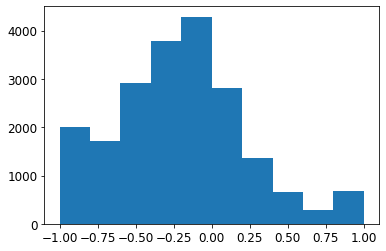

In [ ]:
X_test_scaled = scaler_minmax.transform(X_train_pca)
print(np.allclose(X_train_pca, scaler_minmax.inverse_transform(X_test_scaled)))
plt.hist(X_test_scaled.flatten())

## Scale the POD coefficients between [-1, 1]

- X and R are normalised -> however, the POD coefficients ${\alpha} = \mathbf{R}\mathbf{X}$ are not.
- scale them such that representing the space in an efficient form

In [ ]:
print(X_train_pca.min())
print(X_train_pca.max())
print(X_test_scaled.max())
print(X_test_scaled.min())

-303.04085147910695
475.15055604402625
1.0000000000000002
-1.0


In [ ]:
#NO longer need this cell?
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler((-1,1))
# X_train_scaled = scaler.fit_transform(X_train_pca)
# #np.allclose(X_train_pca, scaler.inverse_transform((X_train_scaled+1)/2))

The function `concat_timesteps(X_train, ntimes, step)` takes in a 2D array, picks 9 time levels at a time and skips time levels if needed.  

In [ ]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat) 

In [ ]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

# X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat = concat_timesteps(X_test_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("X_train_concat_flatten: ", X_train_concat_flatten.shape)


X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

X_train_concat:  (401, 9, 50)
X_train_concat_flatten:  (401, 450)
X_train_4d:  (401, 9, 50, 1)


### Load the GAN

Data from compression using PCA (43 pod coefficients)

In [ ]:
# loading saved model
from tensorflow.keras.models import load_model
# generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410.h5', compile=False).layers
# generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_TRY.h5', compile=False).layers
# generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_TRY_15000.h5', compile=False).layers
# generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_TRY_20000.h5', compile=False).layers
generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_TRY_20000_2.h5', compile=False).layers
# scaler = joblib.load('scaler-gan.pkl')

In [ ]:
# np.random.seed(0)
# tf.random.set_seed(0)

np.random.seed(42)
tf.random.set_seed(42)
latent_space = 150

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler_weights = MinMaxScaler((1,3))
weights = np.ones(shape=(50,))
# pca_vals = scaler_weights.fit_transform(pca.singular_values_.reshape(-1, 1))

weight = tf.constant(weights, dtype=tf.float32)
weight

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

Predicting whole simulation

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-3, 0.9)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("inp: ", inp)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("outp:", outp)
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    """ Finds the loss between the first n-1 generated values and n-1 real values with the nth value as the prediction"""
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [ ]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output
    

In [ ]:
n = 0
# real_coding = X_train_concat[n].reshape(1,-1)
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

tic = time.time()

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(446):
    t1 = time.time()
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000) #epochs=1000
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print(i)
    tmc = time.time()
    print ('\n\nTime : ', tmc - t1, 'sec')

X_predict = np.array(X_predict)
#X_predict_TEST = np.array(X_predict)
toc = time.time()
print ('\n\nTime : ', toc - tic, 'sec')

inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
0


Time :  1.579317331314087 sec
1


Time :  1.5308098793029785 sec
2


Time :  1.5441200733184814 sec
3


Time :  1.5461578369140625 sec
4


Time :  1.5214784145355225 sec
5


Time :  1.5430316925048828 sec
6


Time :  1.5302696228027344 sec
7


Time :  1.5288052558898926 sec
8


Time :  1.4400107860565186 sec
9


Time :  1.456892967224121 sec
10


Time :  1.4238183498382568 sec
11


Time :  1.4200453758239746 sec
12


Time :  1.4688663482666016 sec
13


Time :  1.5021729469299316 sec
14


Time :  1.5318427085876465 sec
15


Time :  1.5301222801208496 sec
16


Time :  1.5269715785980225 sec
17


Time :  1.541355848312378 sec
18


Time :  1.5394833087921143 sec
19


Time :  1.530280590057373 sec
20


Time :  1.534125566482544 sec
21


Time :  1.5484509468078613 sec
22


Time :

In [ ]:
# print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())

TESTING 

In [ ]:
# np.allclose(X_predict_TEST, X_predict)
# #print(np.array(X_predict).shape)

In [ ]:
# #print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
# real_coding_TEST = X_train_concat[n].reshape(1,-1)
# real_coding_TEST = real_coding_TEST[:,10:]
# real_coding_TEST = tf.constant(real_coding_TEST)
# real_coding_TEST = tf.cast(real_coding_TEST, dtype=tf.float32)
# print(generator(latent_values)[:,ntimes:,:,:].shape)
# print(real_coding_TEST.shape)
# print('prediction Loss: ', mse_loss(generator(latent_values)[:,ntimes:,:,:], real_coding_TEST, weight).numpy())

In [ ]:
# ###
# plt.plot(pred_loss[0:9])  
# plt.plot(pred_loss)
# plt.show()

In [ ]:
# X_generated = scaler_minmax.inverse_transform(X_predict)
# print(X_generated.shape)
# sensor_generated = X_generated[:, 43:]
# X_generated = pca.inverse_transform(X_generated[:, :43]).reshape((455,43))
# print(X_generated.shape)
# print(X_generated.max())
# print(X_generated.min())


END TEST SECTION

In [ ]:
# gen_out = generator(latent_values, training=False)
# print(gen_out.shape)
# gen = gen_out[0].numpy().reshape(9, 50)

#GAN_inverse = scaler_minmax.inverse_transform(X_predict).reshape((409,50))
GAN_inverse = scaler_minmax.inverse_transform(X_predict).reshape((455,50))
# GAN_inverse = scaler_minmax.inverse_transform(X_predict_TEST).reshape((455,50))
print(GAN_inverse.shape)
split_inv = np.split(GAN_inverse, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)
 
X_recovered = pca.inverse_transform(alpha)
print(X_recovered.shape)

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(455, 50)
(455, 43)
GAN shape output of sensor CO2:  (455, 7)
(455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


In [ ]:
# norm_sensor_CO2_TEST2 = scaler_enhanced.inverse_transform(sensor_CO2)
# print(np.allclose(norm_sensor_CO2_TEST, norm_sensor_CO2_TEST2))
# # Between optimisation runs - the results differ

In [ ]:
# sensor_1 = []
# sensor_2 = []
# sensor_3 = []
# sensor_4 = []
# sensor_5 = []
# sensor_6 = []
# sensor_7 = []
# for i in range(455):
#   sensor_1.append(norm_sensor_CO2_[i, 0] - norm_sensor_CO2_TEST[i,0])
#   sensor_2.append(norm_sensor_CO2_[i, 1] - norm_sensor_CO2_TEST[i,1])
#   sensor_3.append(norm_sensor_CO2_[i, 2] - norm_sensor_CO2_TEST[i,2])
#   sensor_4.append(norm_sensor_CO2_[i, 3] - norm_sensor_CO2_TEST[i,3])
#   sensor_5.append(norm_sensor_CO2_[i, 4] - norm_sensor_CO2_TEST[i,4])
#   sensor_6.append(norm_sensor_CO2_[i, 5] - norm_sensor_CO2_TEST[i,5])
#   sensor_7.append(norm_sensor_CO2_[i, 6] - norm_sensor_CO2_TEST[i,6])
# print(sensor_1)

20000_2 results - time: 17:00pm, 07-08-2021


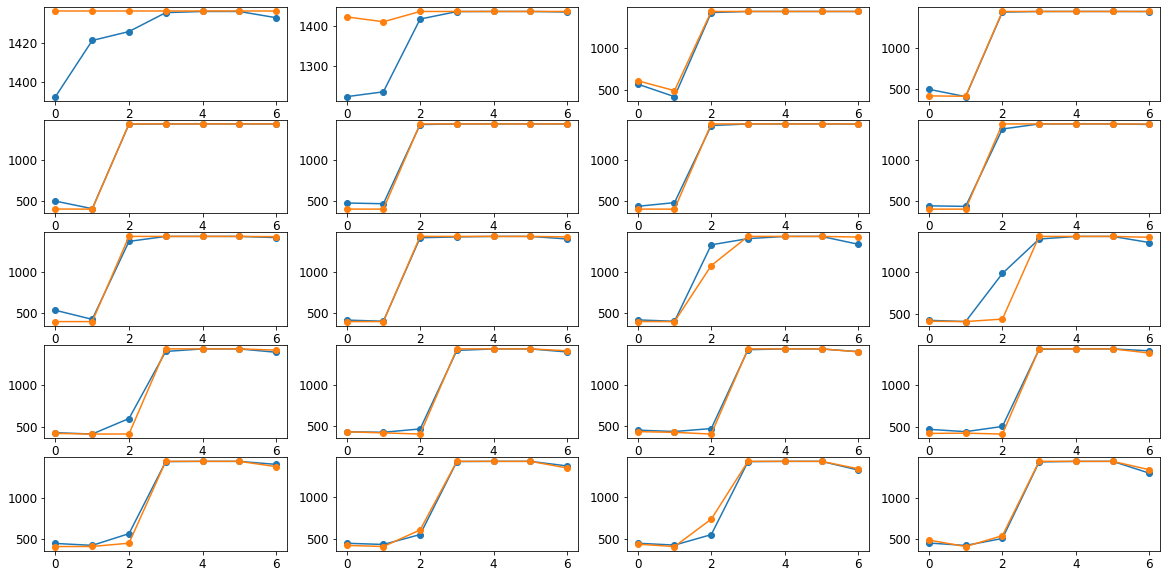

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[i,:], '-o')

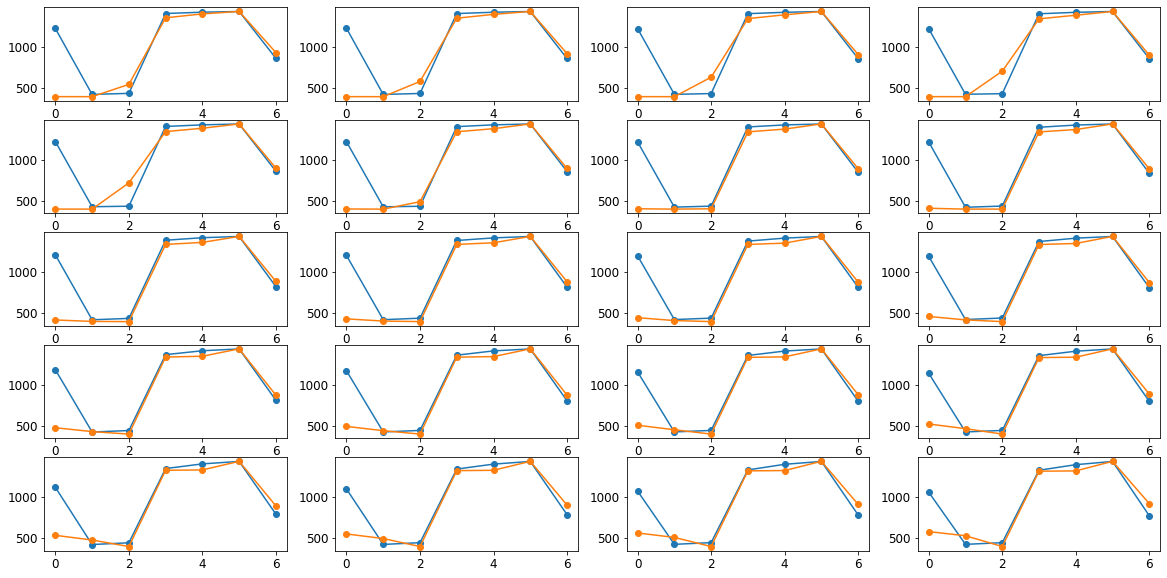

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[80+i,:], '-o')

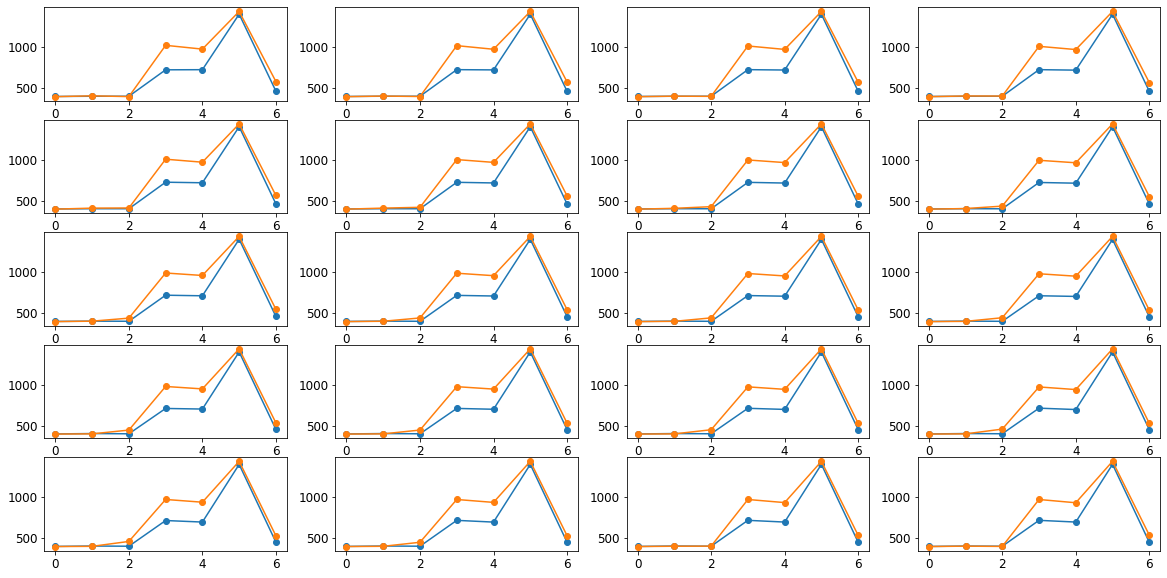

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[200+i,:], '-o')

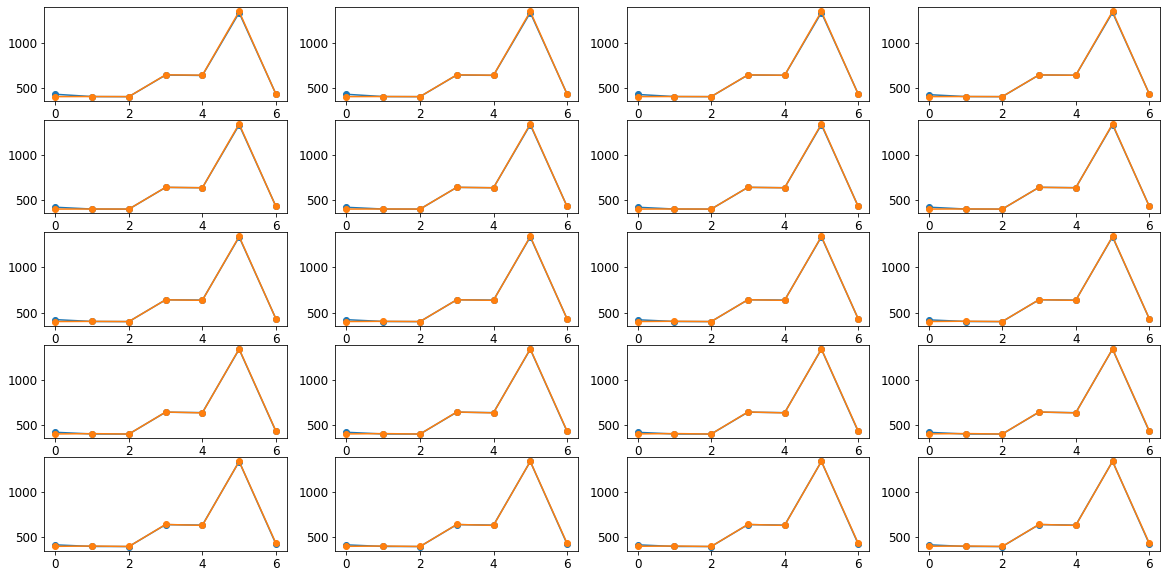

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

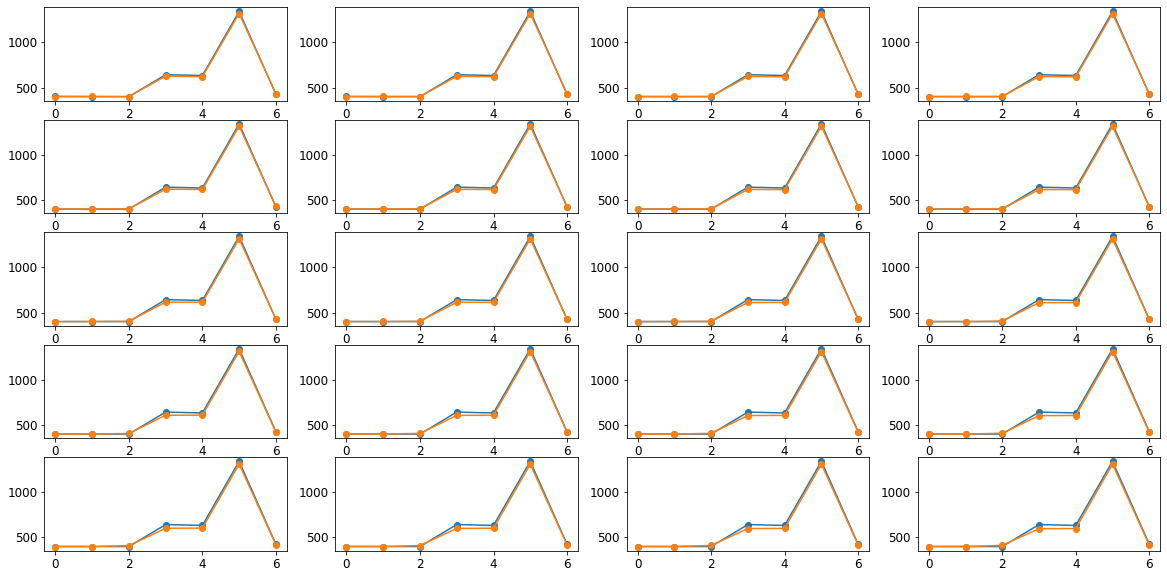

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[435+i,:], '-o')

20000_2 results - time: 16:43pm, 07-08-2021


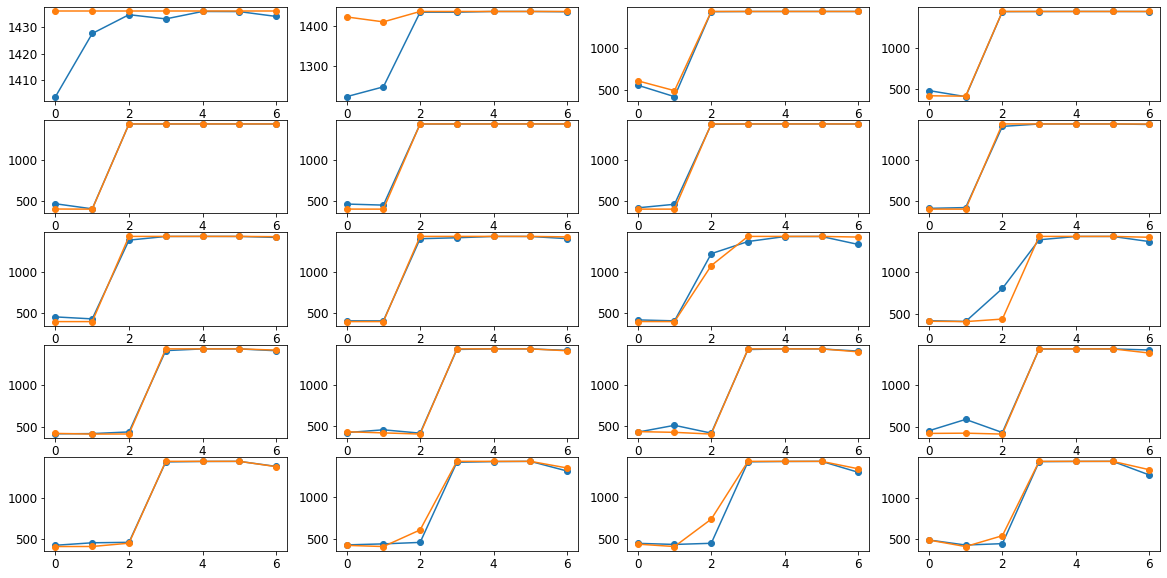

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[i,:], '-o')

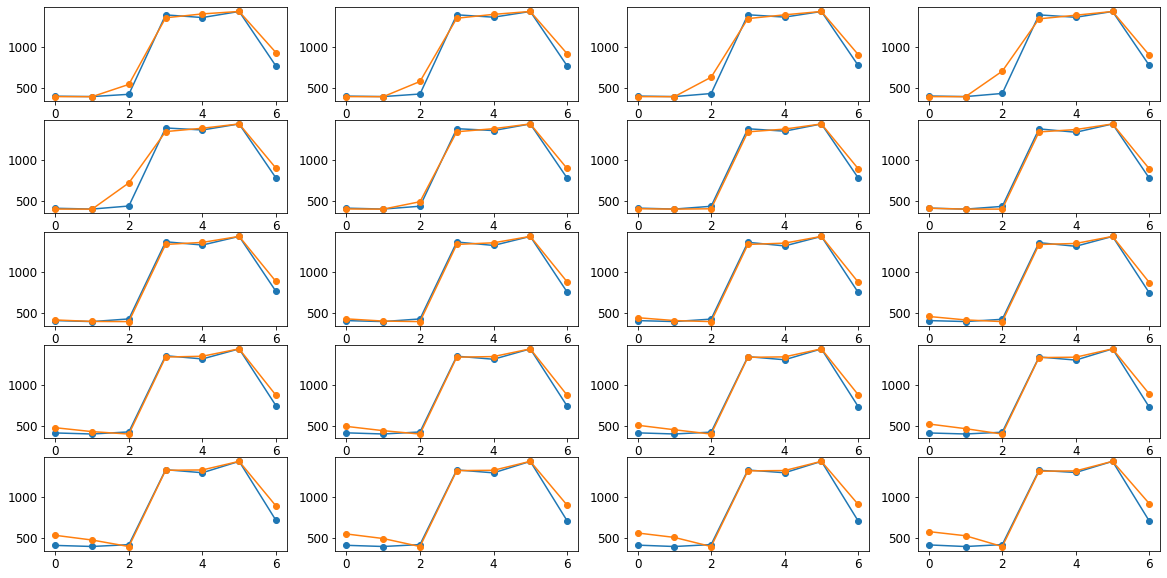

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[80+i,:], '-o')

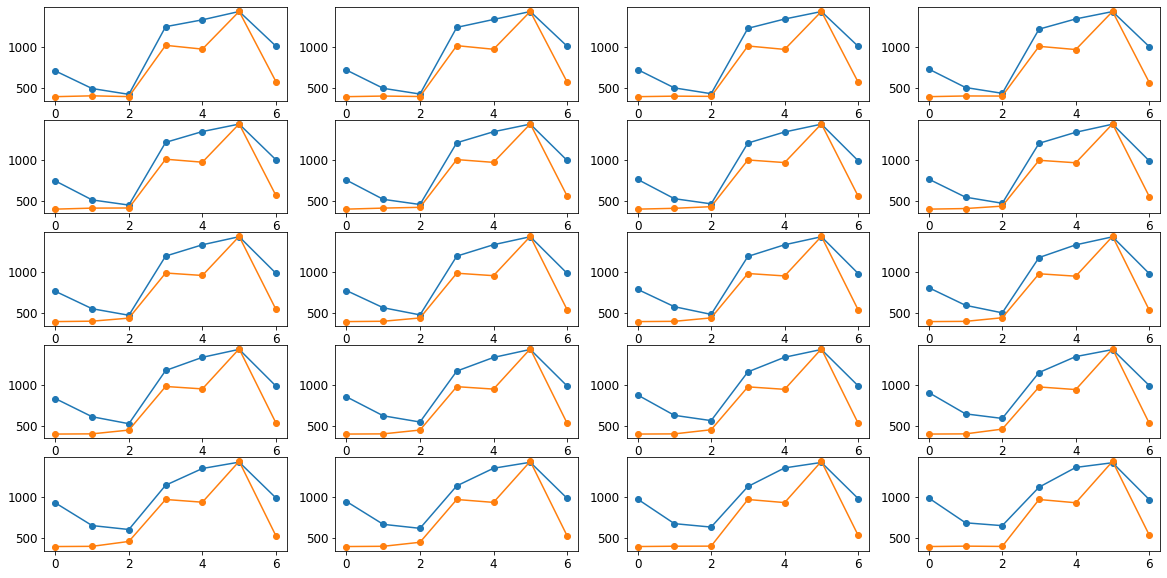

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[200+i,:], '-o')

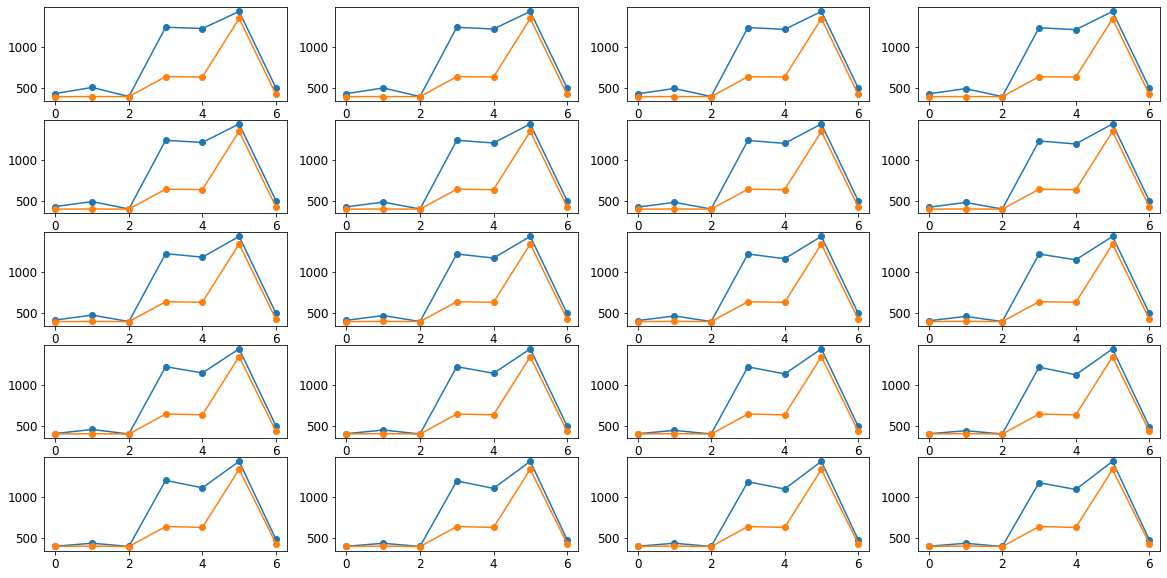

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

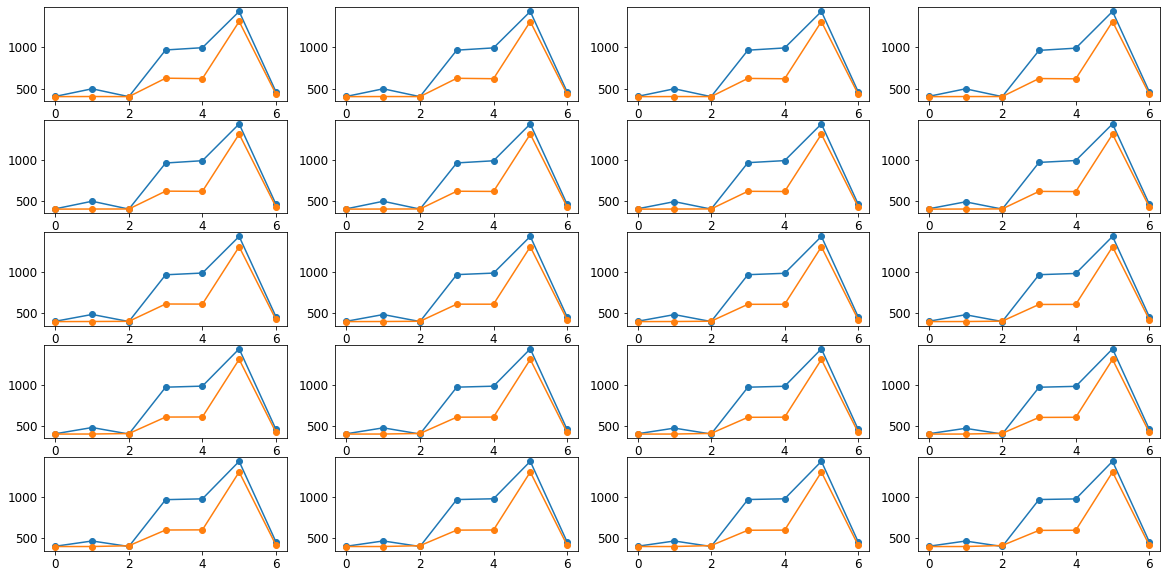

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[435+i,:], '-o')

20000_2 results - time: 22:38pm, 05-08-2021


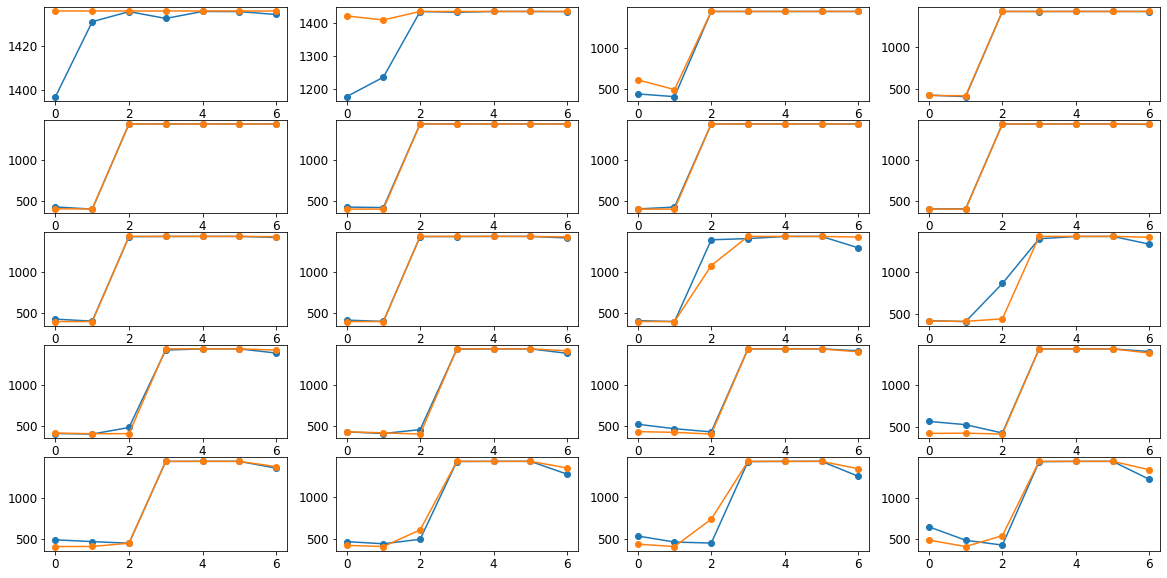

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[i,:], '-o')

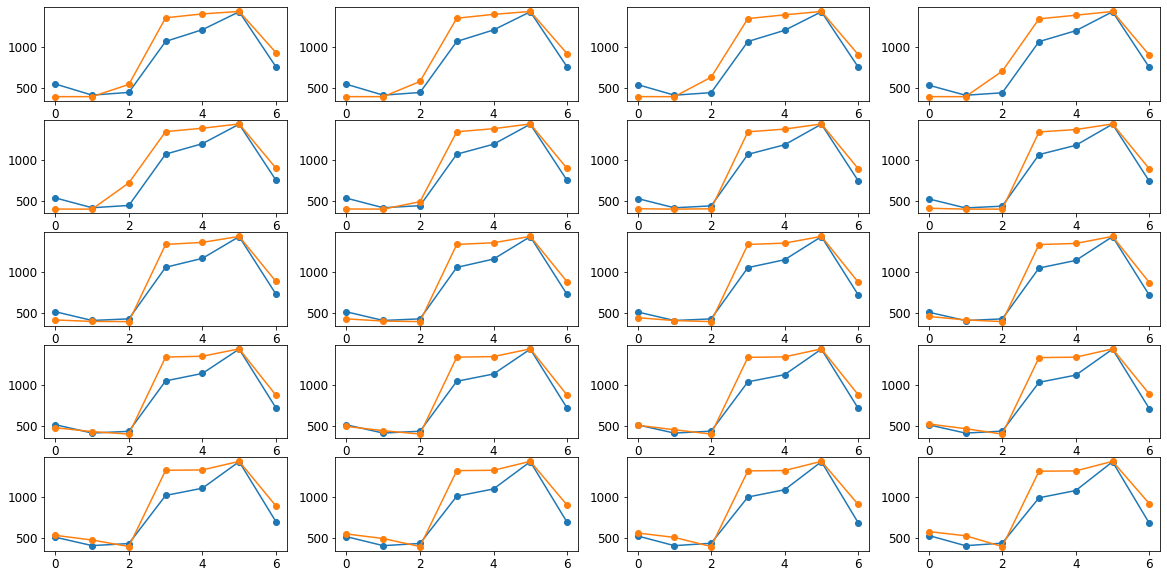

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[80+i,:], '-o')

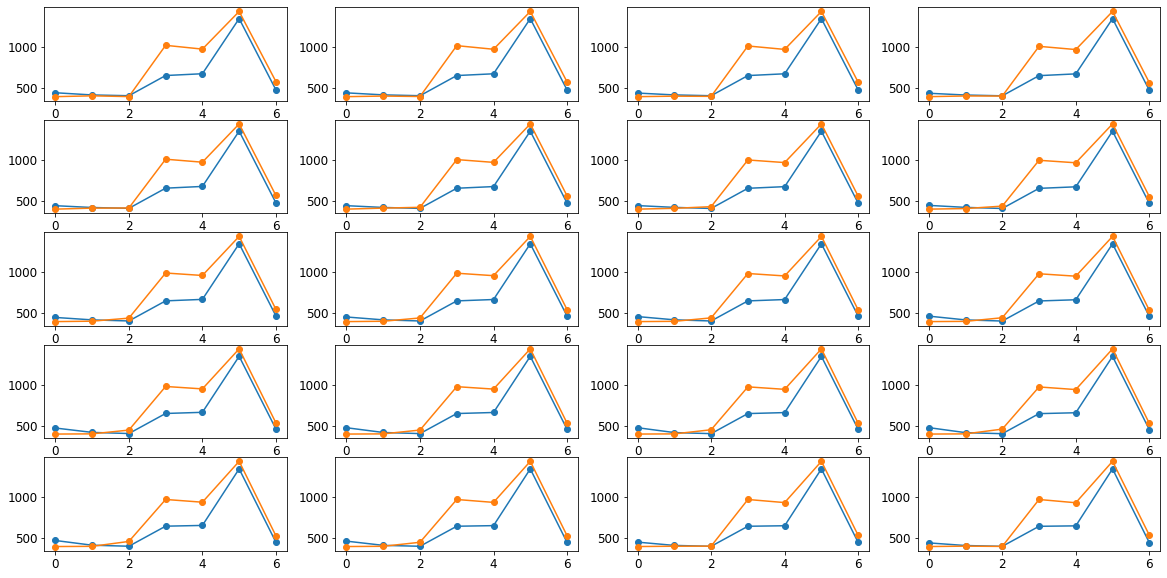

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[200+i,:], '-o')

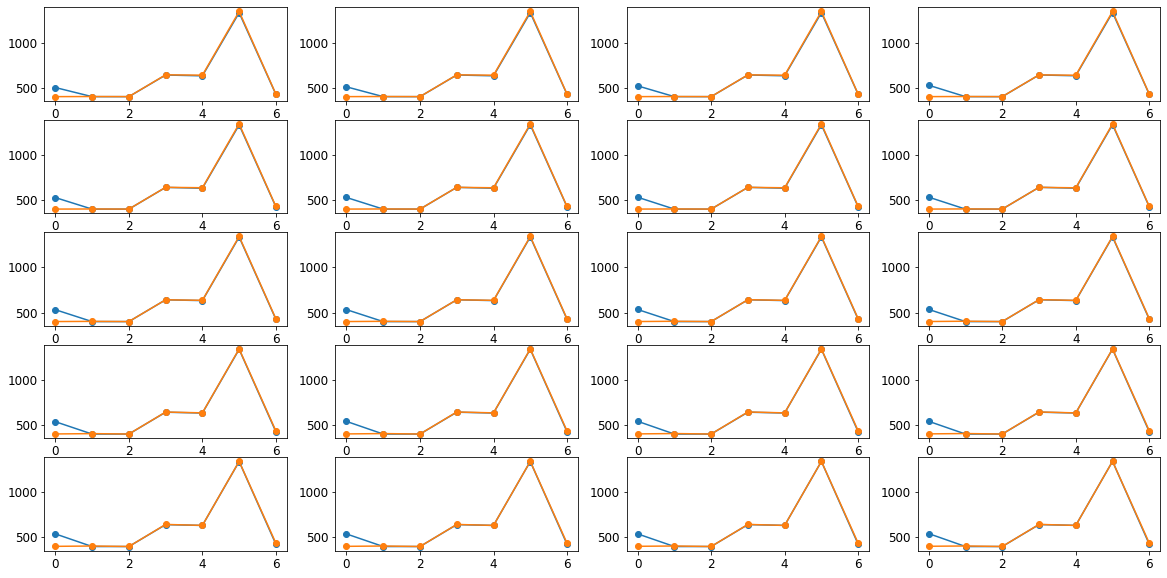

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

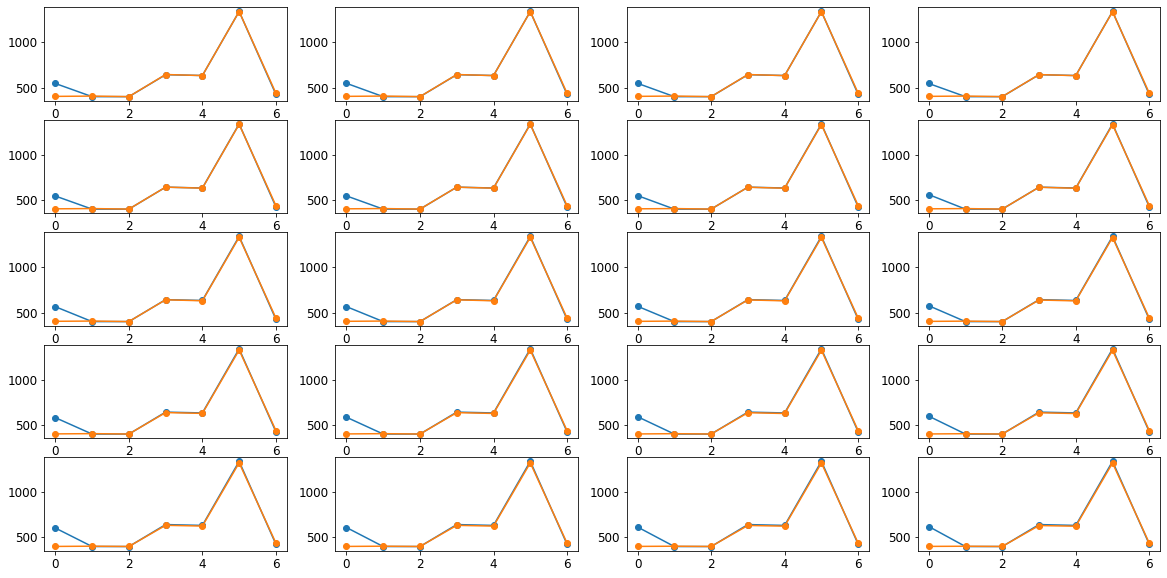

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

20000_2 results - time: 22:21pm

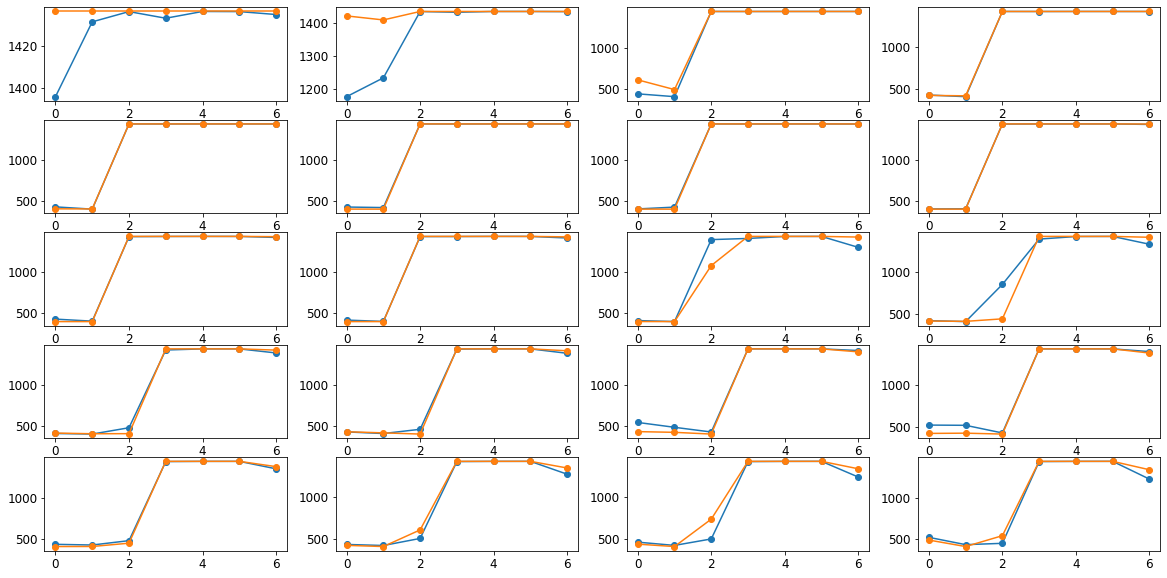

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[i,:], '-o')

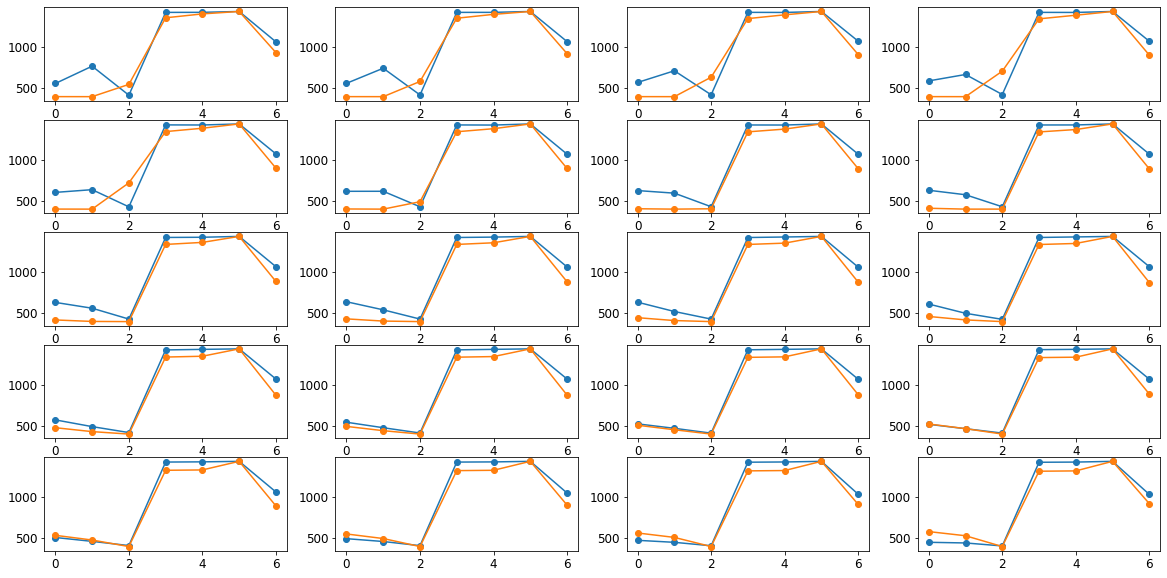

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[80+i,:], '-o')

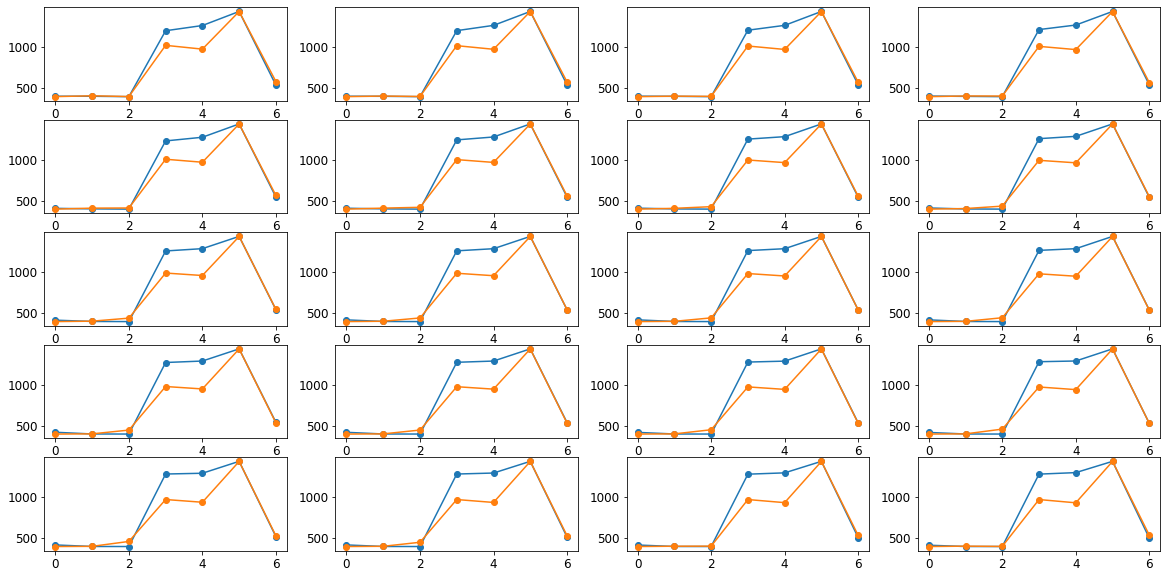

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[200+i,:], '-o')

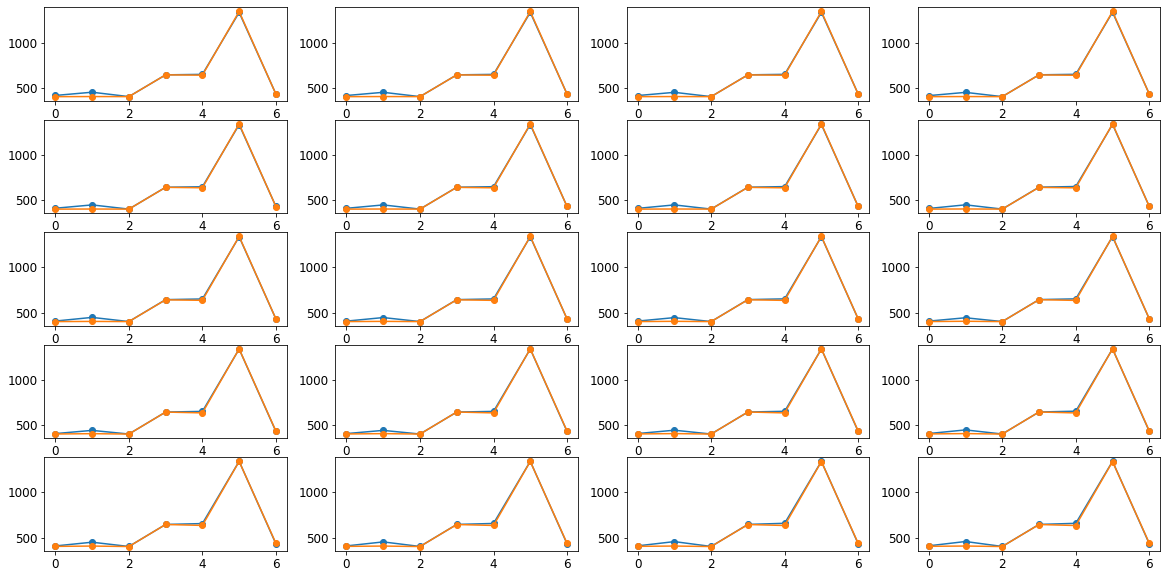

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

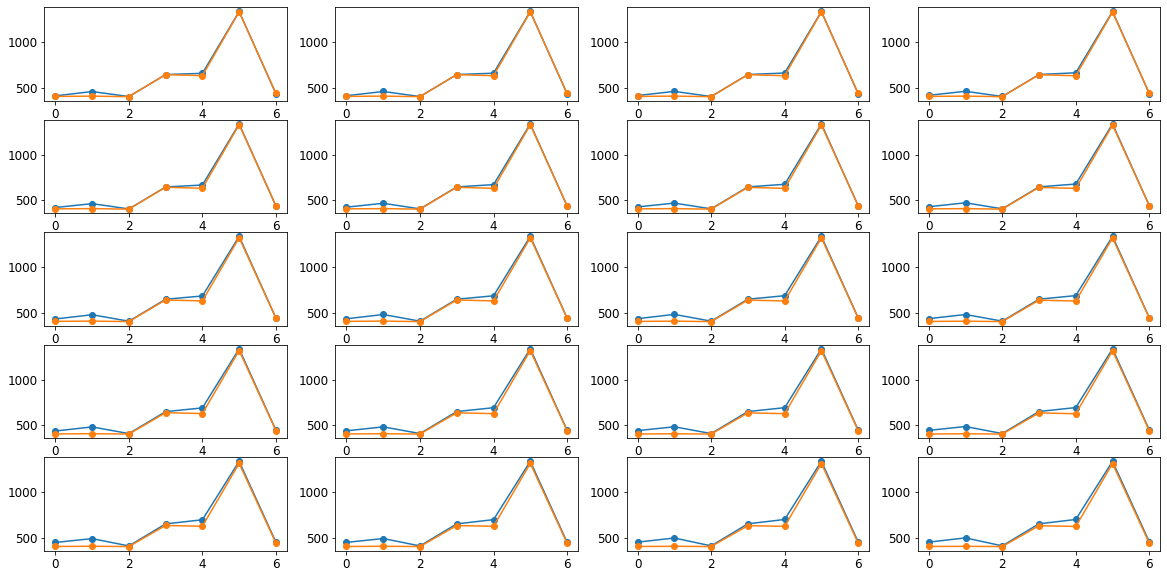

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

Time levels 0-20:

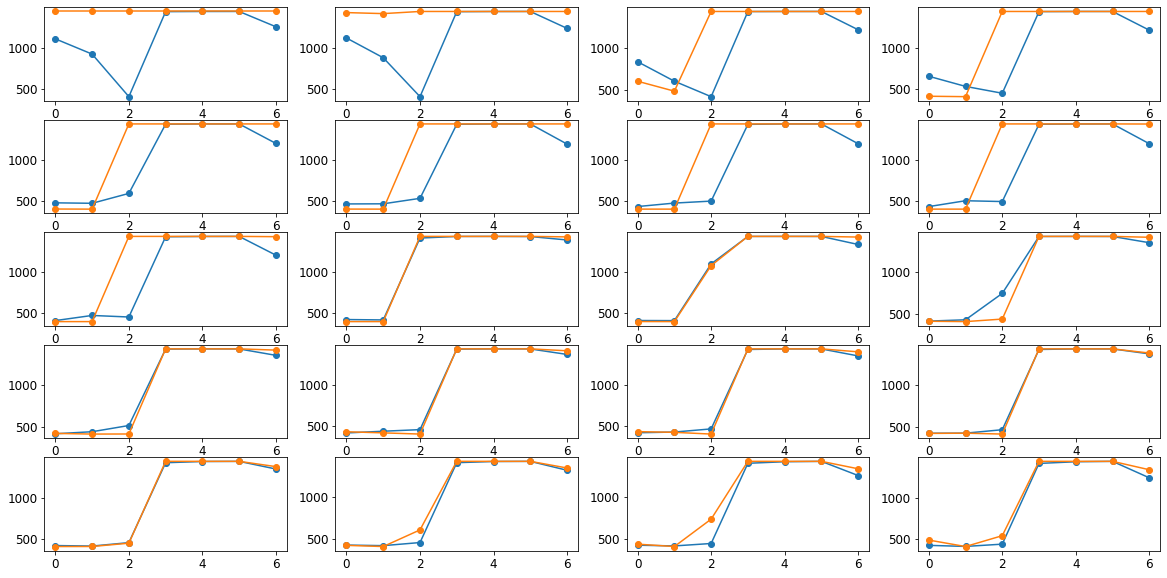

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

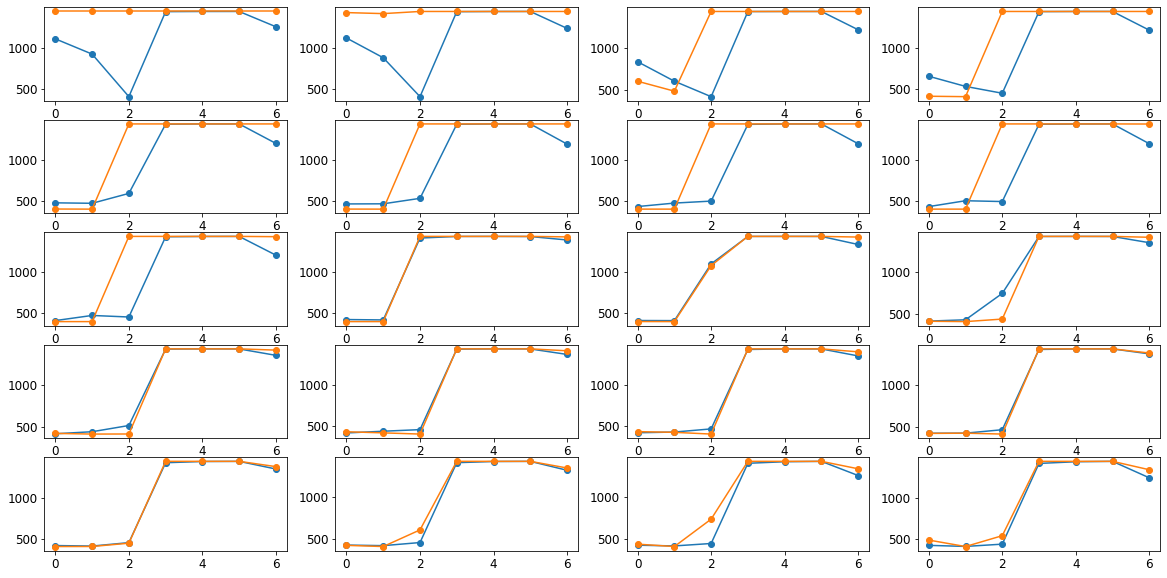

In [ ]:
#04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

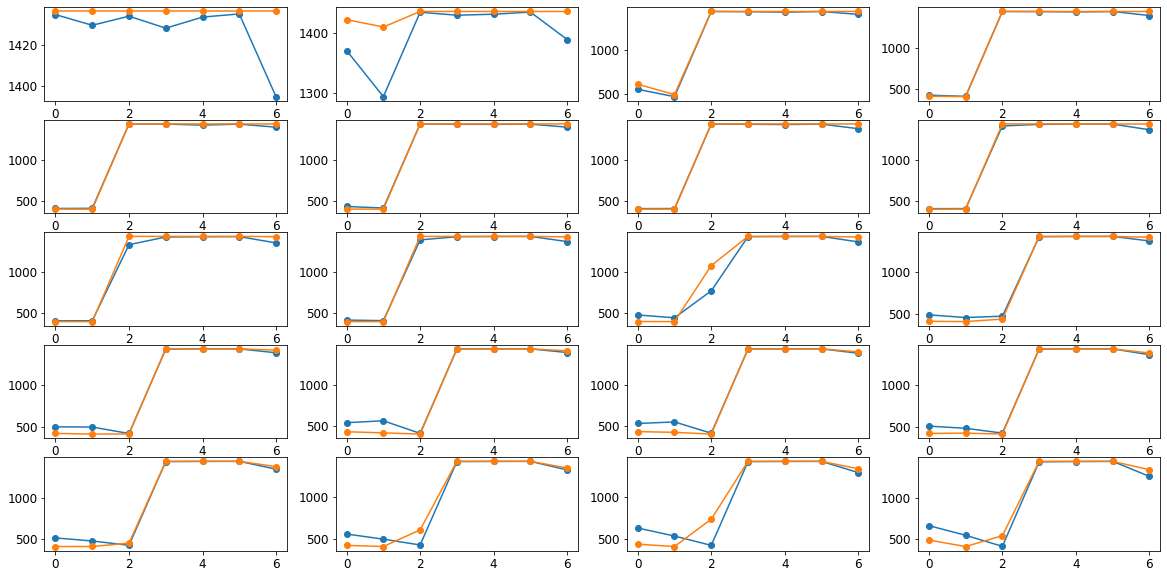

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

Time levels 80-100:

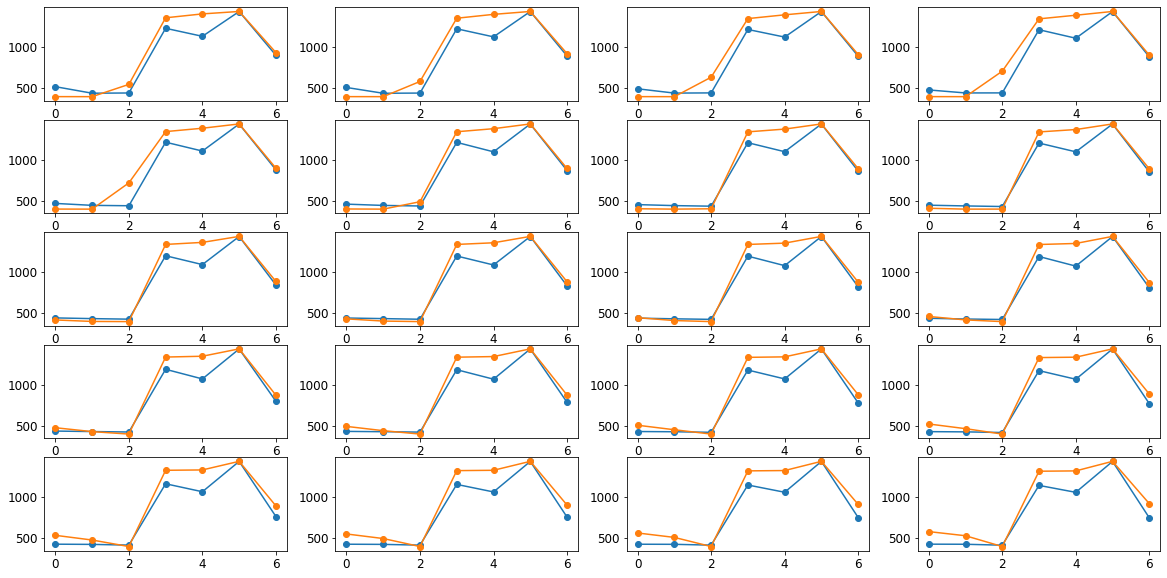

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[80+i,:], '-o')

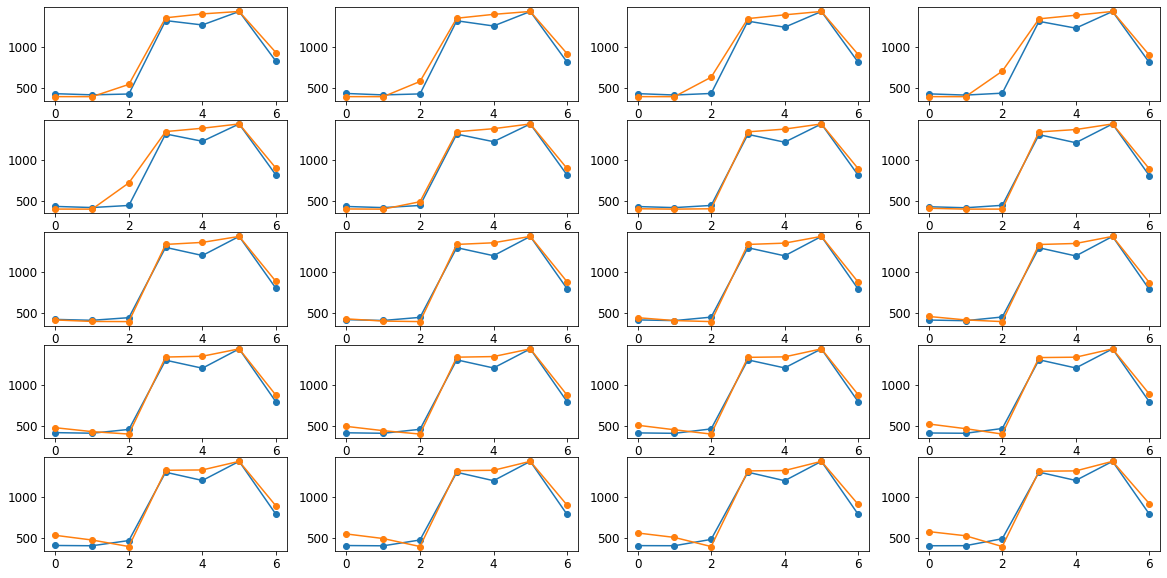

In [ ]:
# 04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[80+i,:], '-o')

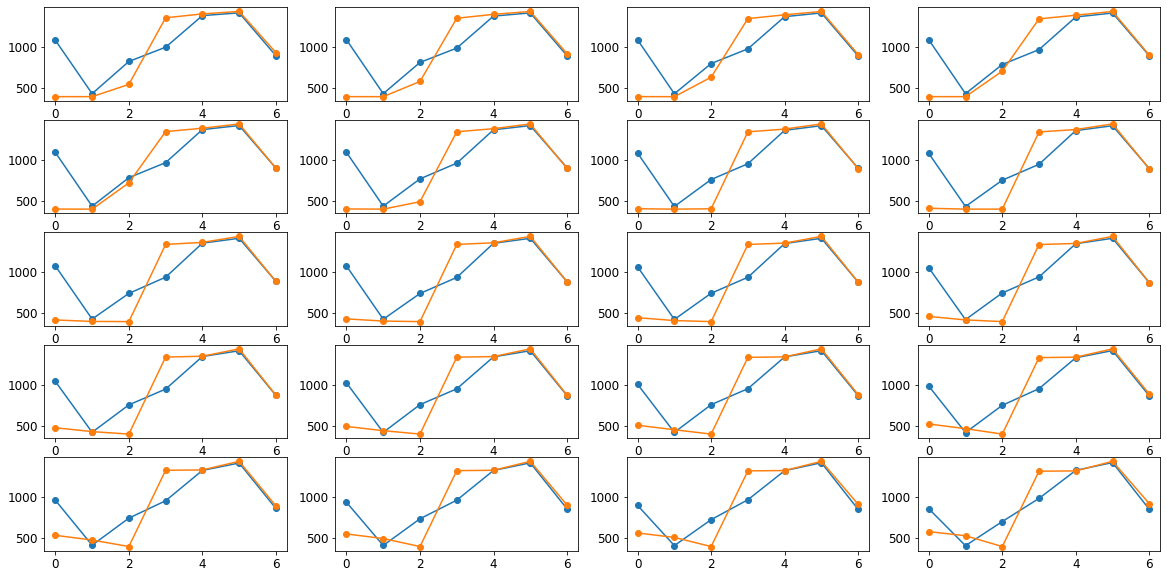

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[80+i,:], '-o')

Time levels 200-220:

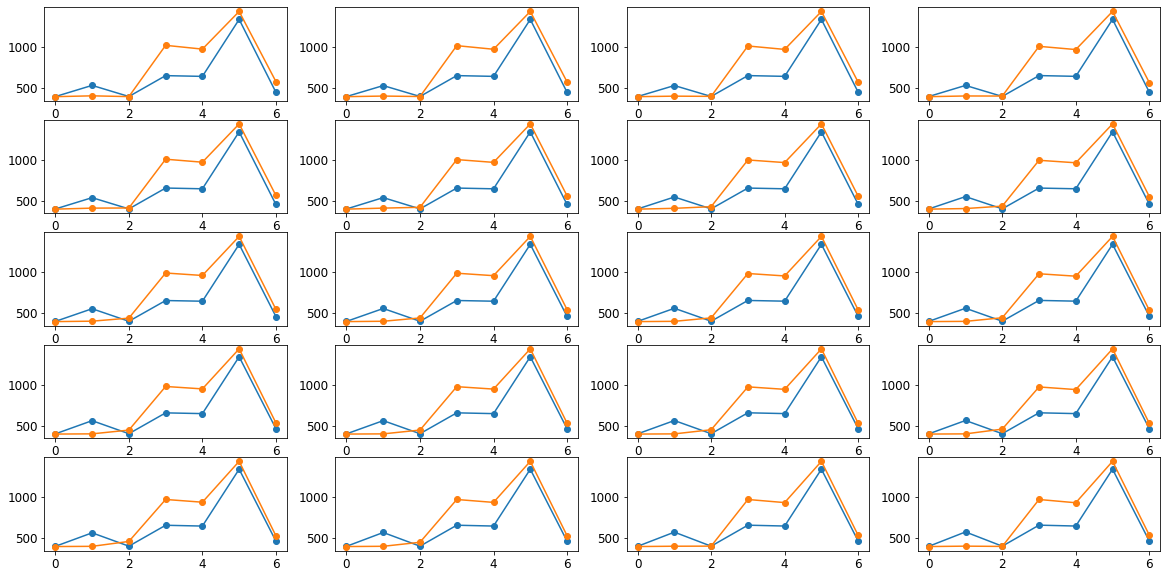

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[200+i,:], '-o')

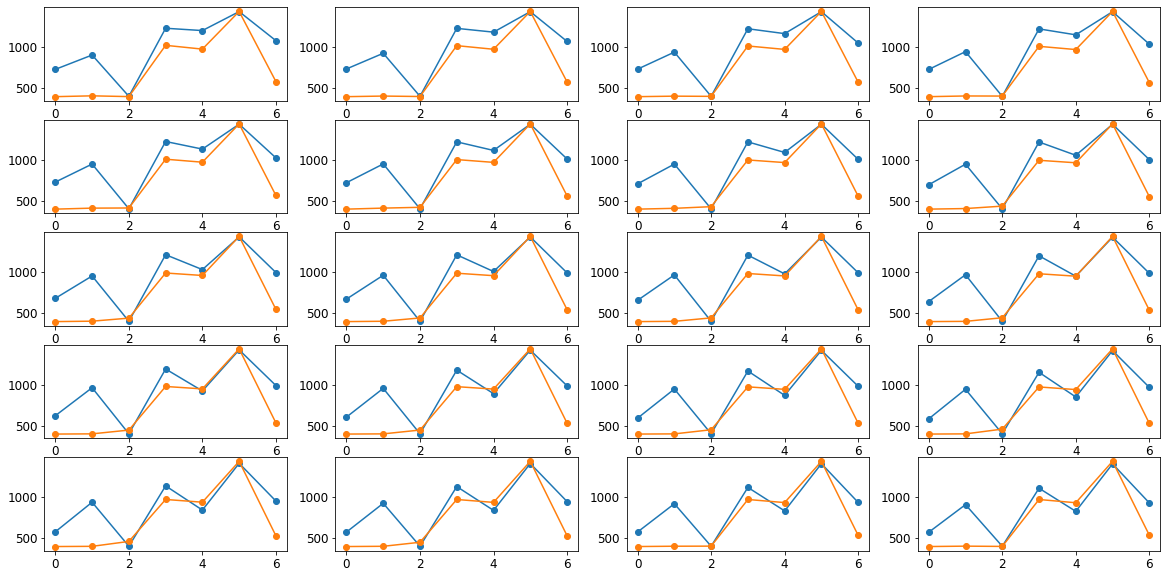

In [ ]:
#04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[200+i,:], '-o')

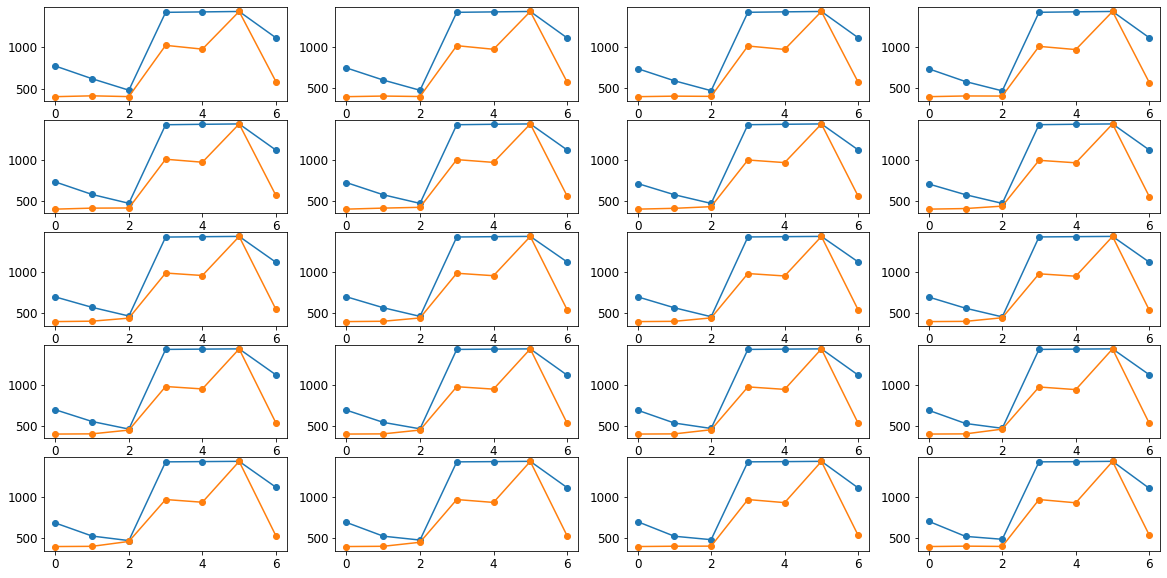

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[200+i,:], '-o')

Time levels 220-240:

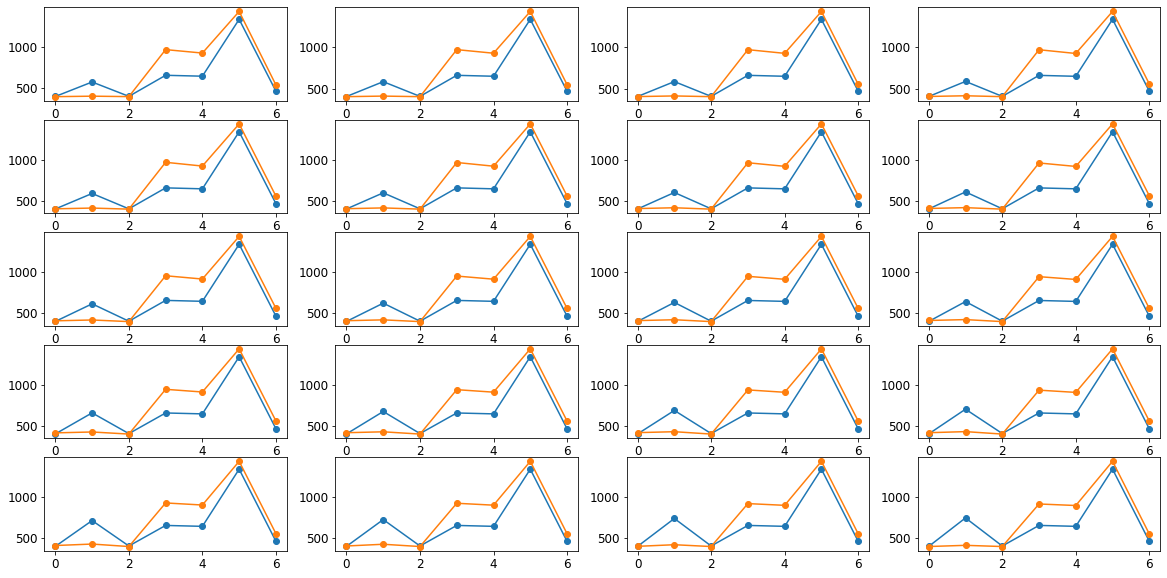

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[220+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[220+i,:], '-o')

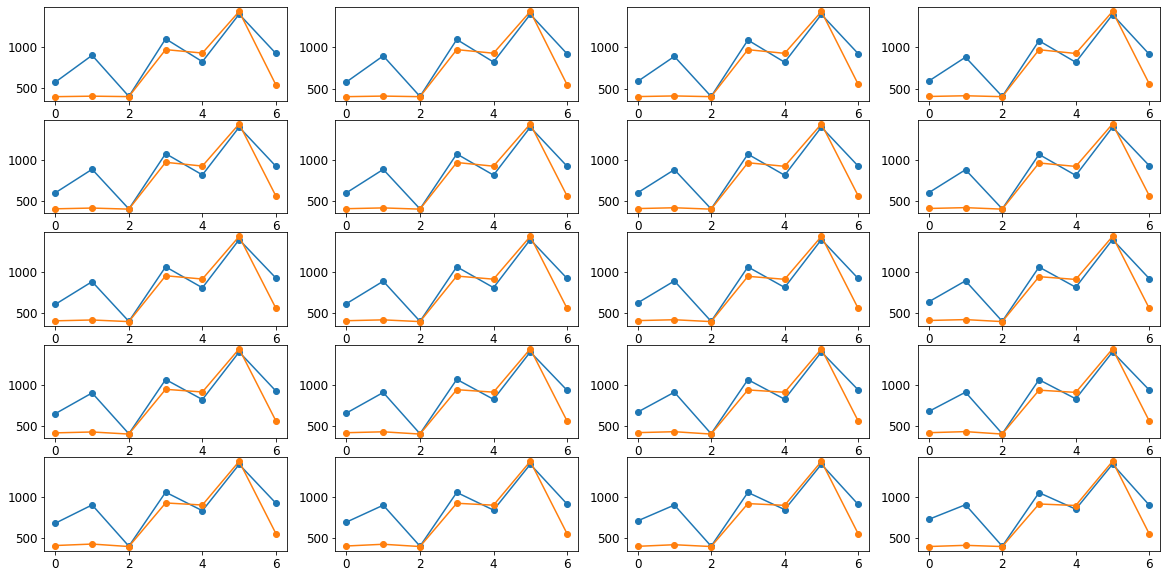

In [ ]:
#04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[220+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[220+i,:], '-o')

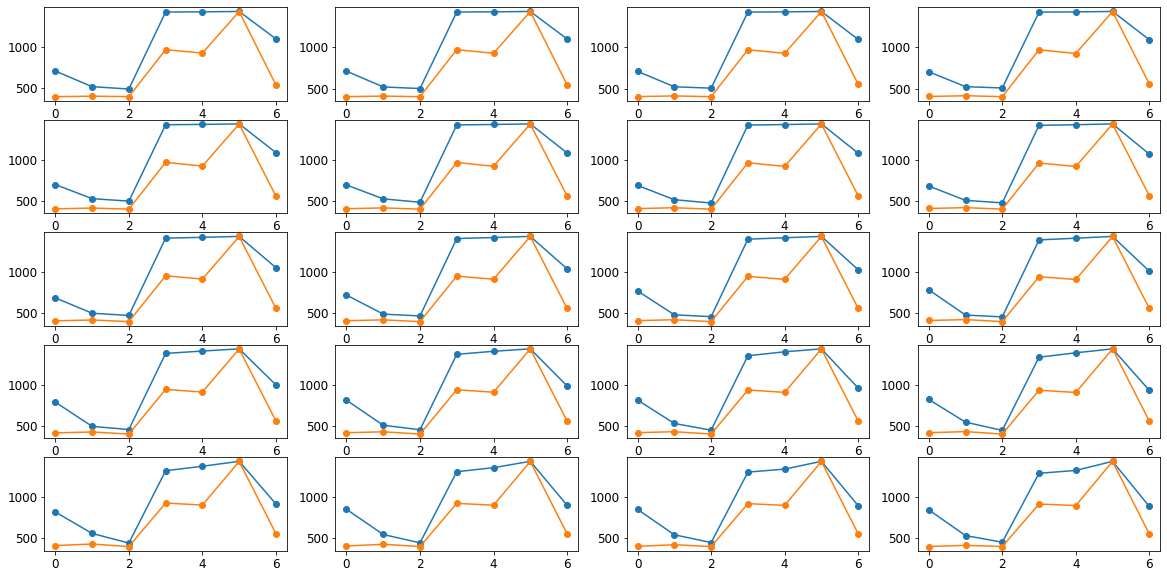

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[220+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[220+i,:], '-o')

Time levels 380-400:

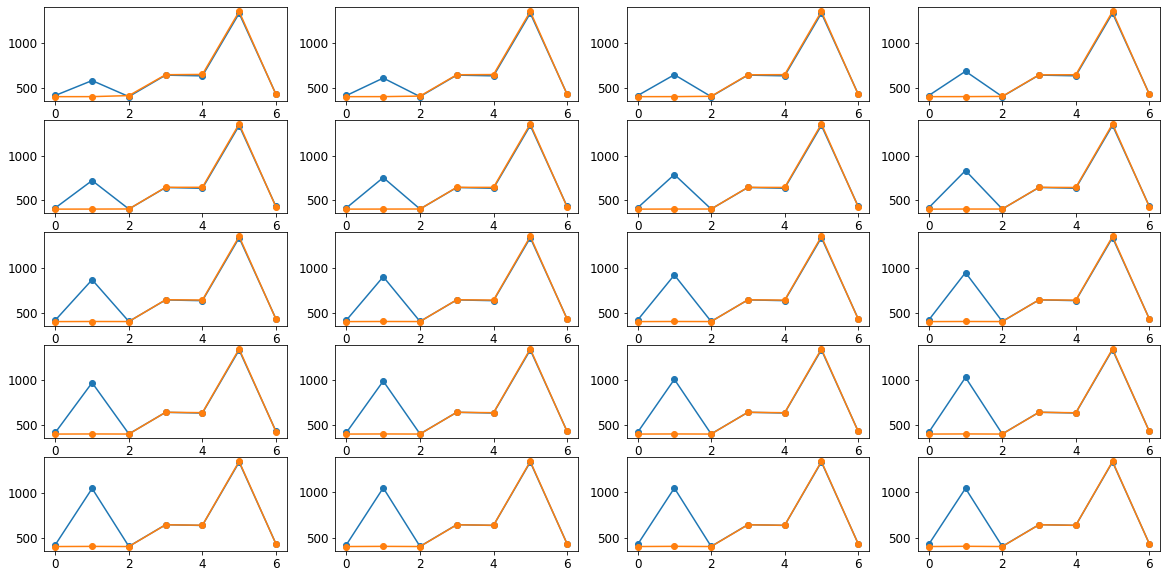

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[380+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[380+i,:], '-o')

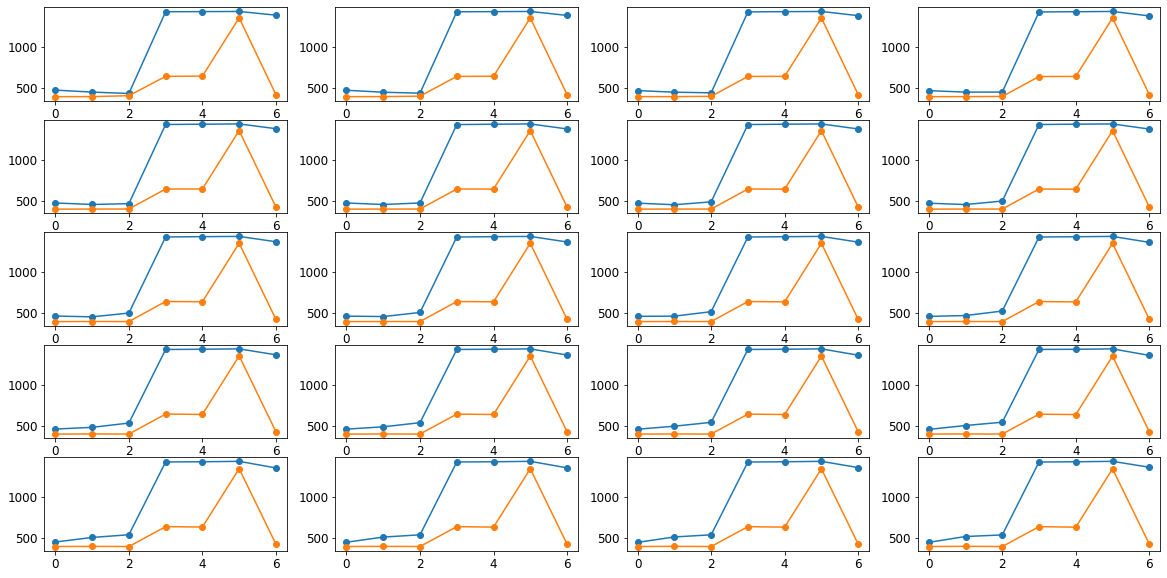

In [ ]:
#04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[380+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[380+i,:], '-o')

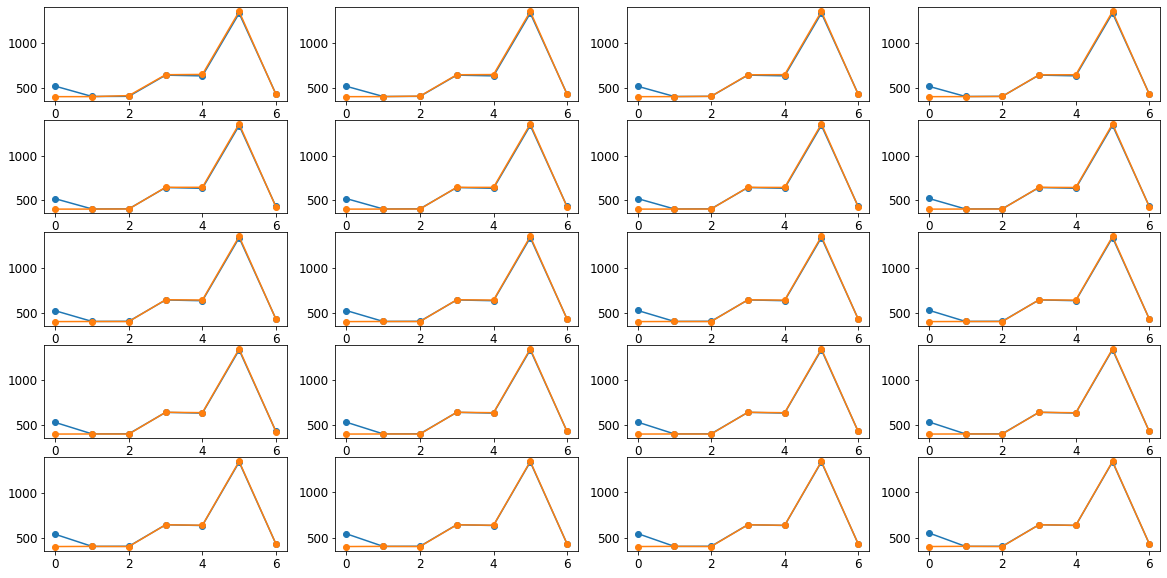

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[380+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[380+i,:], '-o')

Time levels 410-430:
Predicting outside the range of input data time region

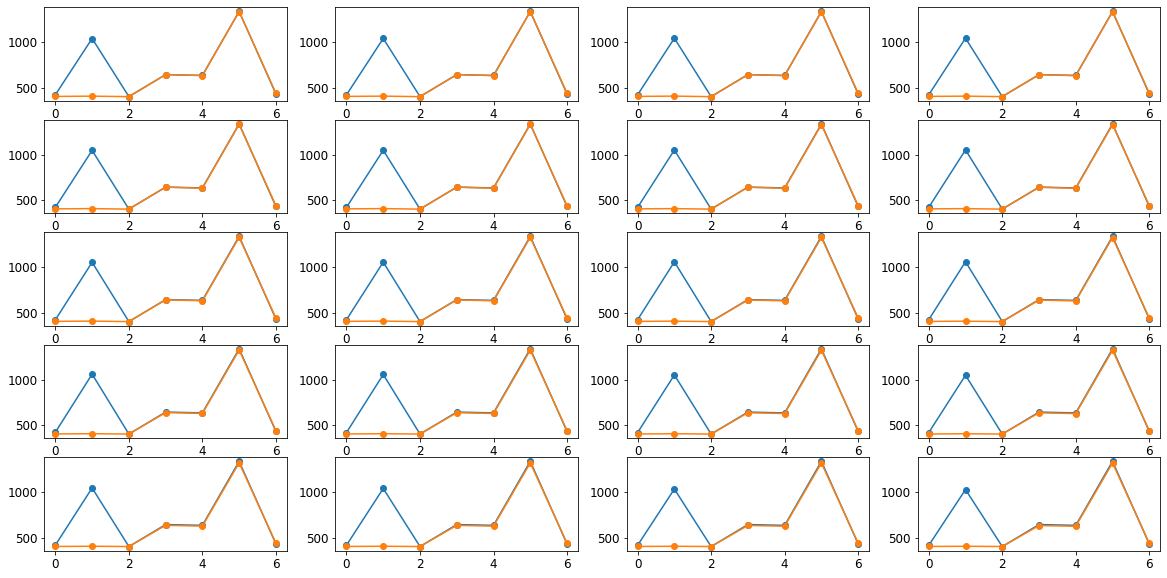

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

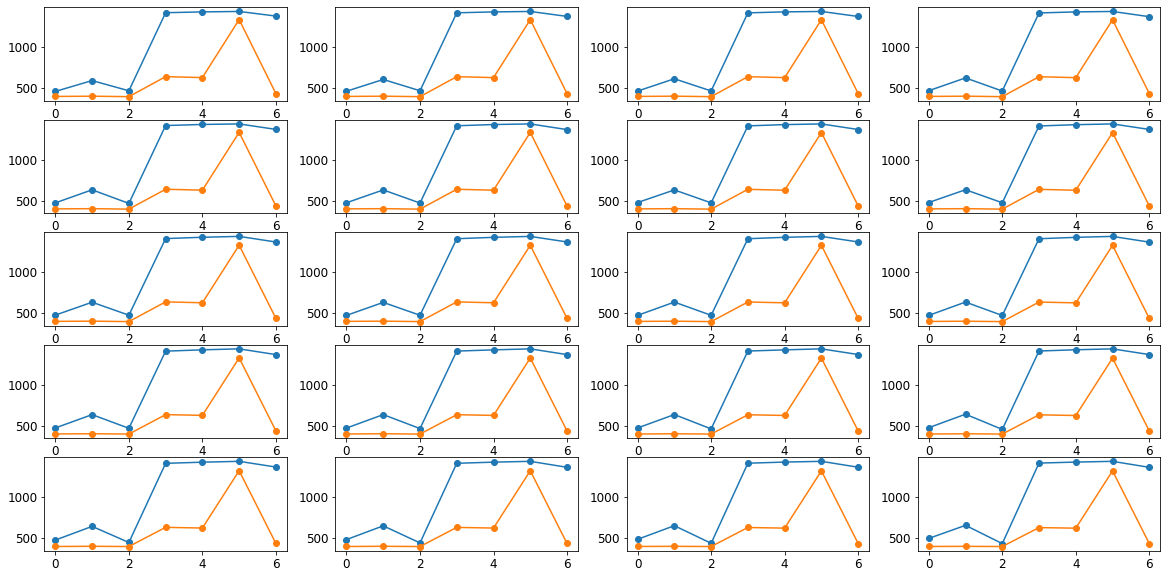

In [ ]:
#04-08
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

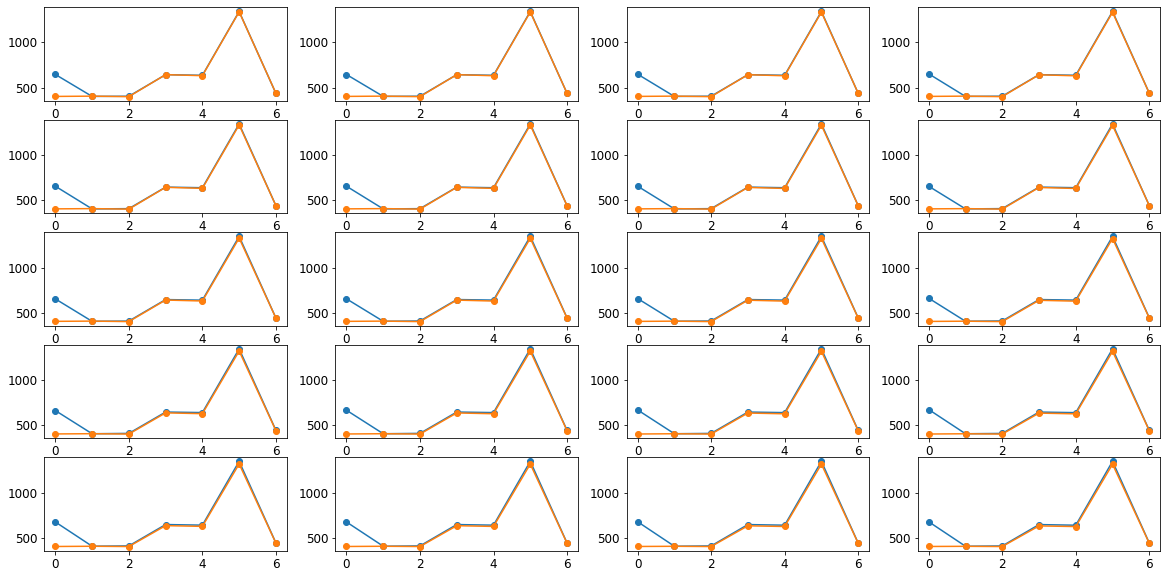

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

15000 epochs


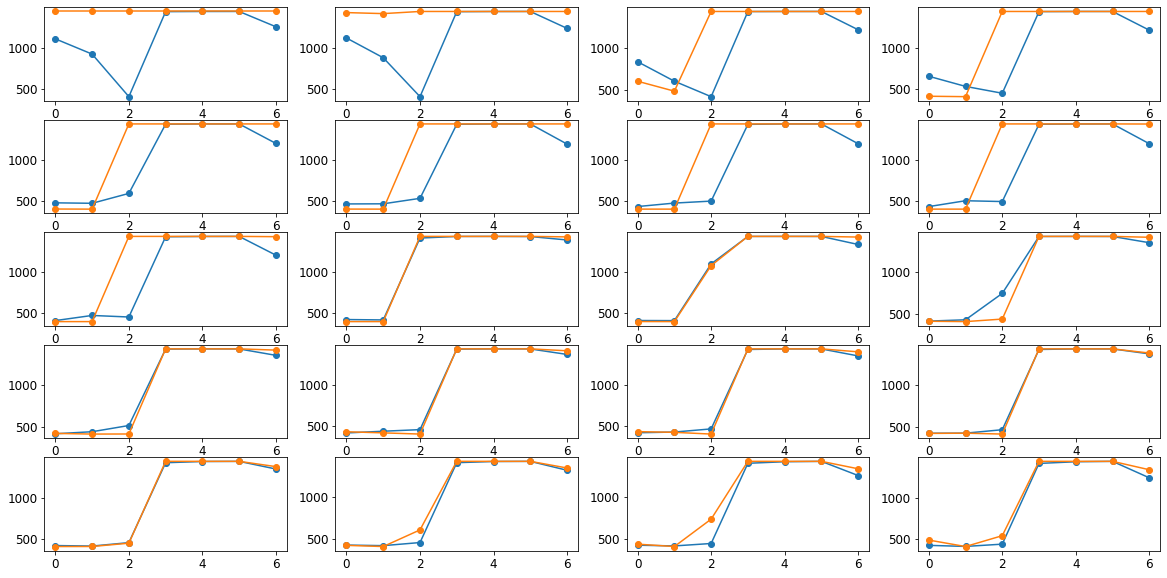

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

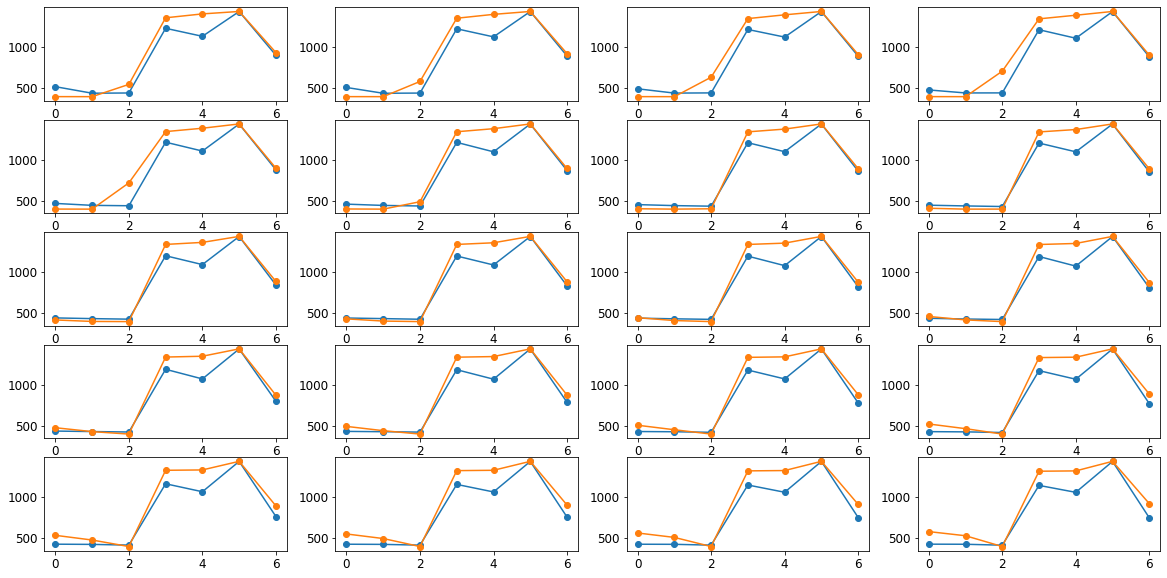

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[80+i,:], '-o')

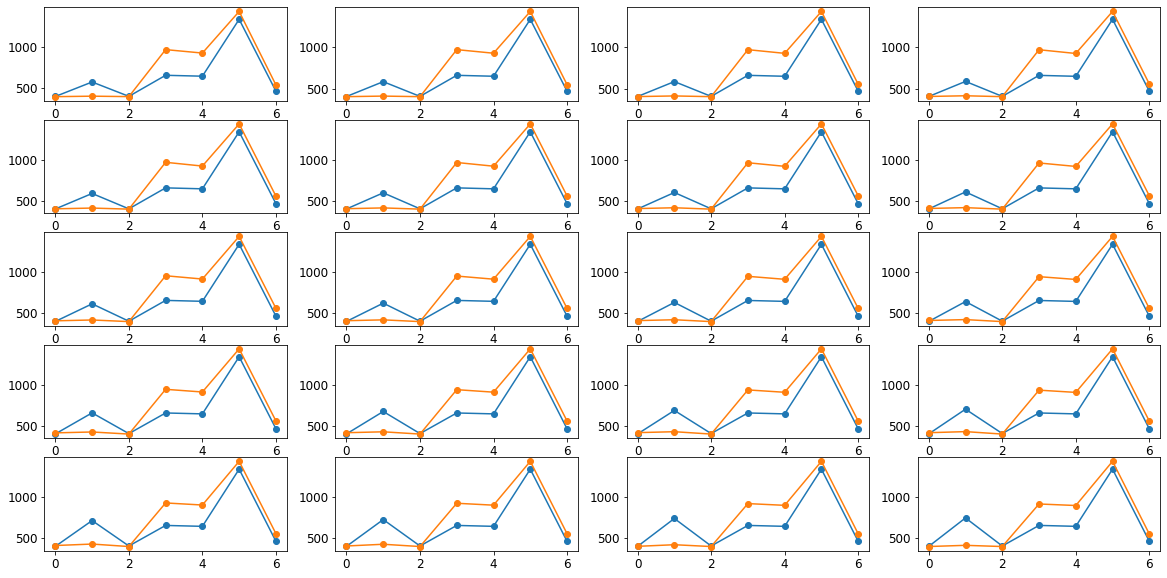

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[220+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[220+i,:], '-o')

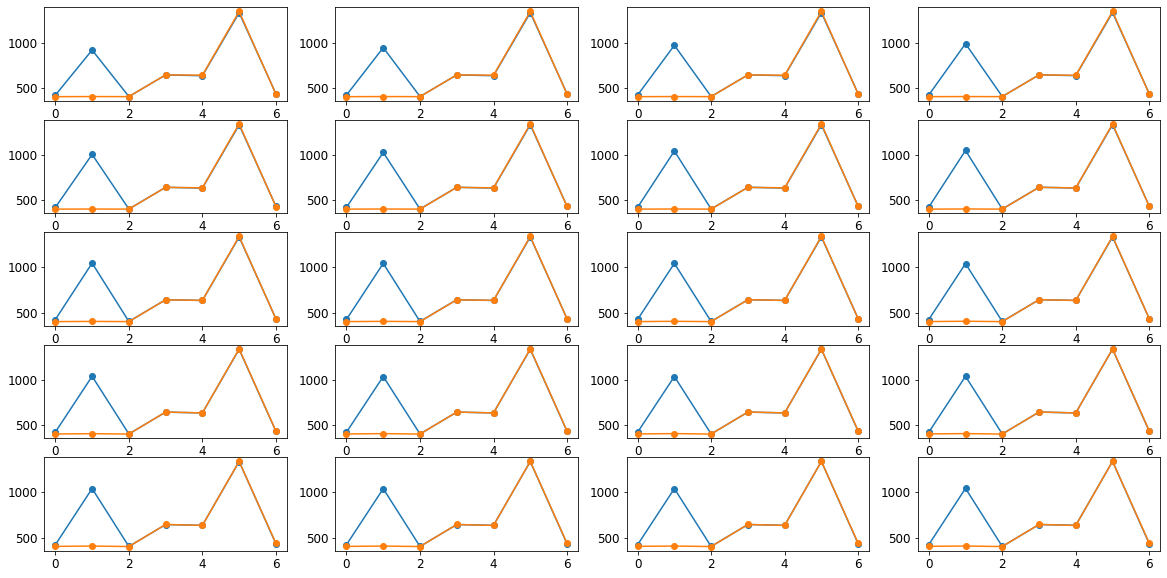

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

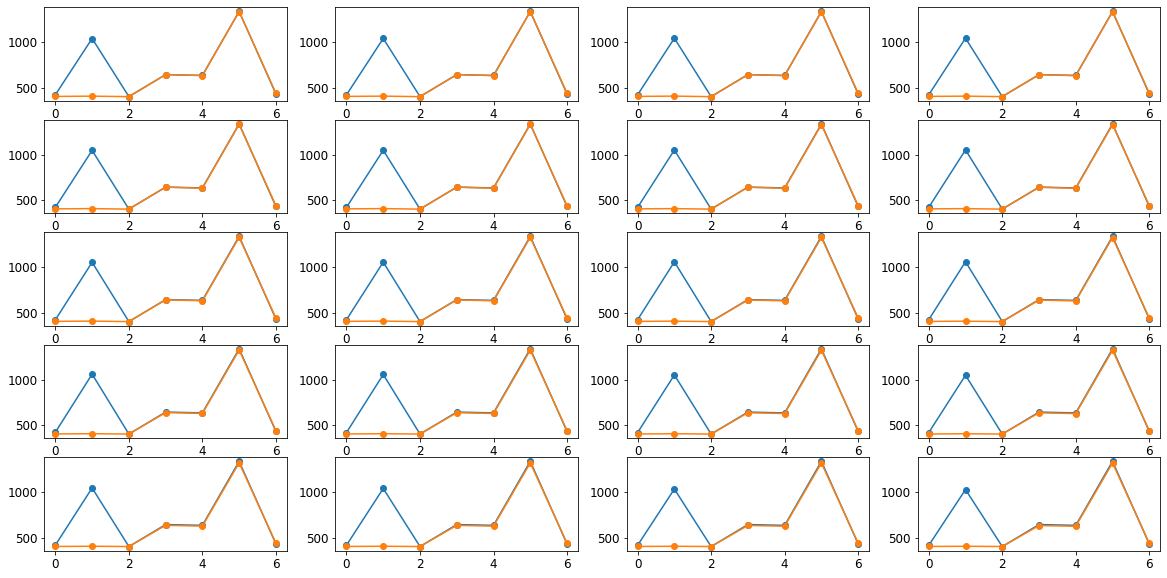

In [ ]:
#04-08 - 15000 epochs
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

20000 epochs

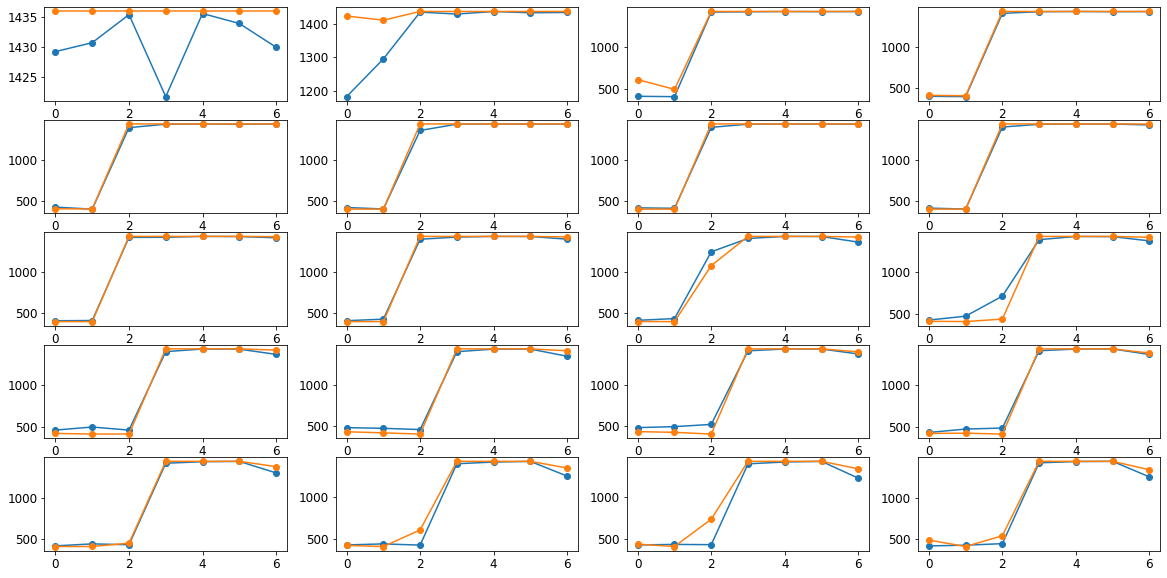

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[i,:], '-o')

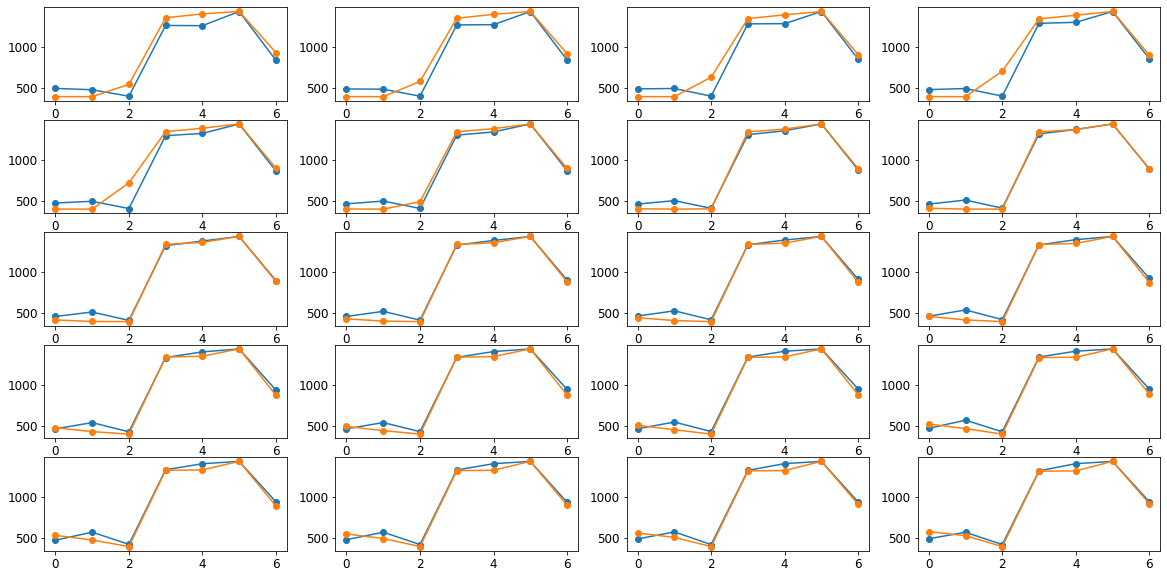

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[80+i,:], '-o')

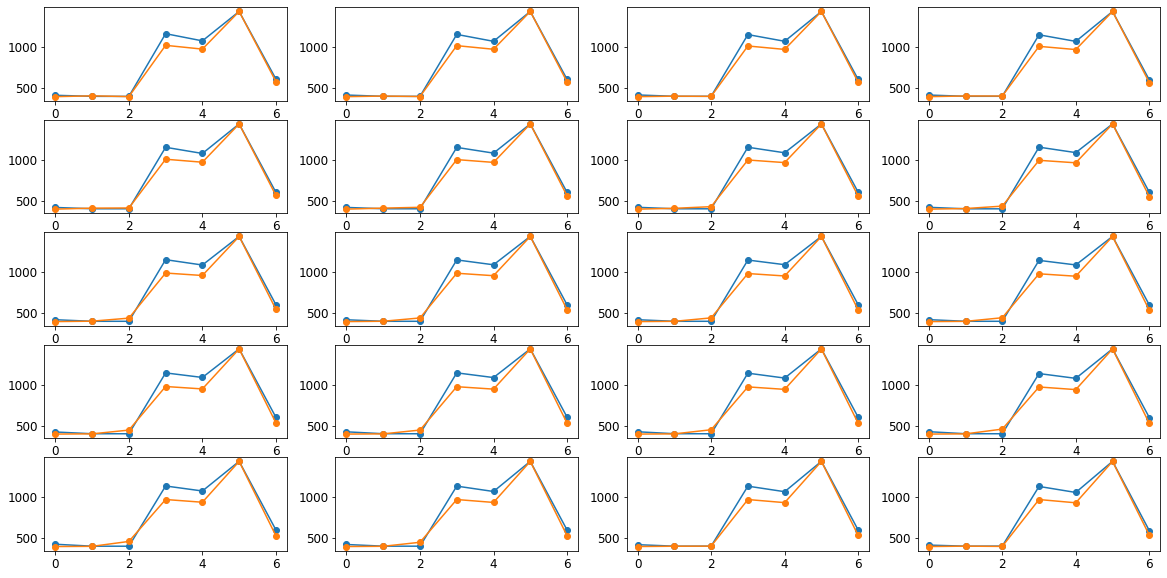

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[200+i,:], '-o')

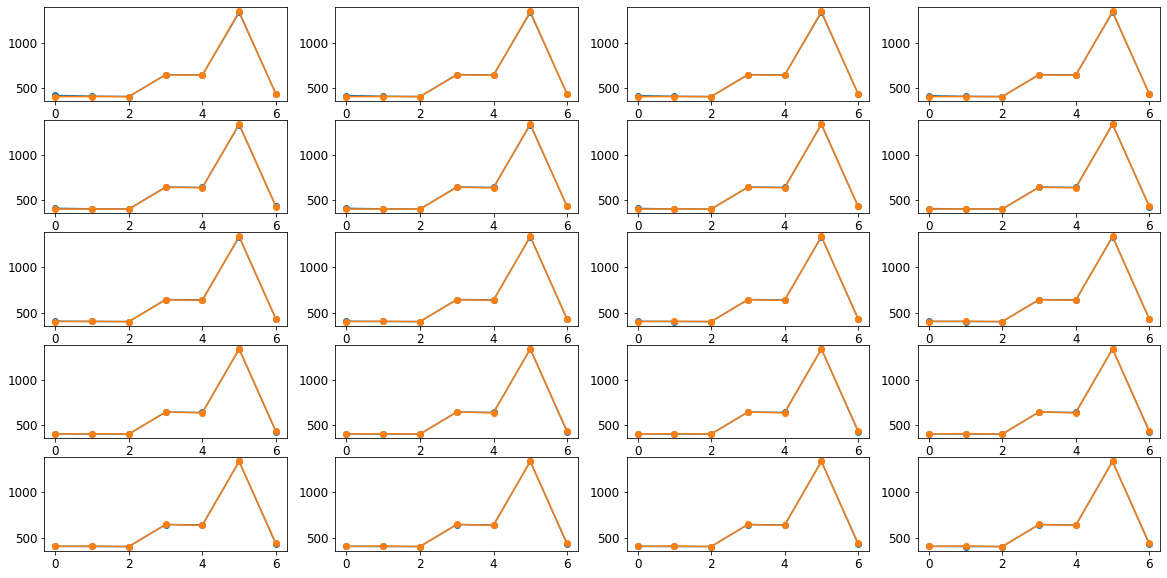

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[390+i,:], '-o')

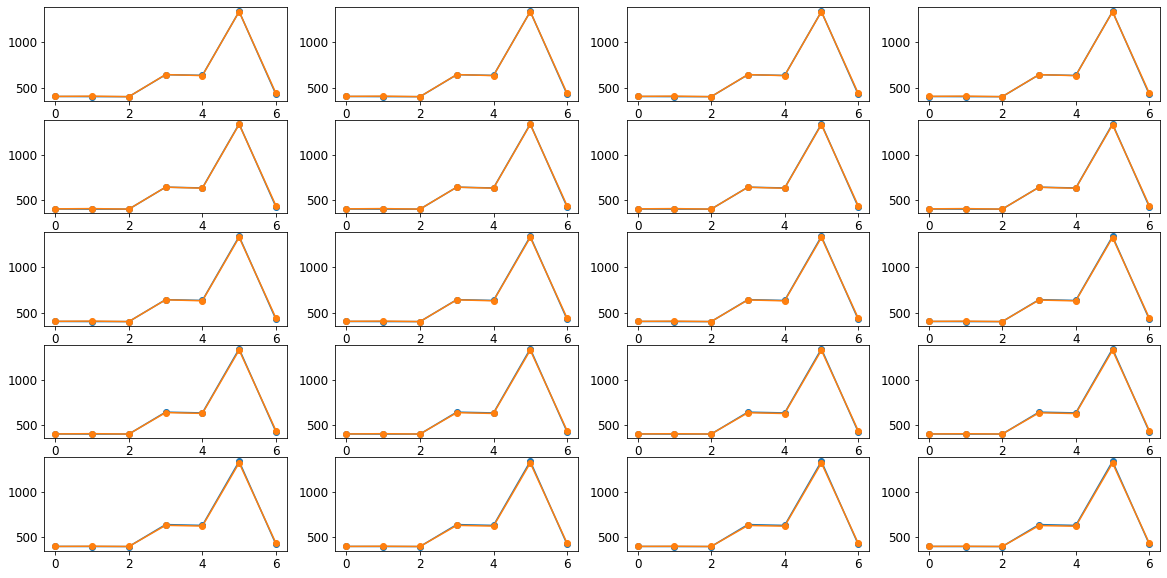

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[410+i,:], '-o')
    ax.flatten()[i].plot(C02_sensor_all[410+i,:], '-o')

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/predictions_410_TRIAL_20000/prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
# writing to vtu file
tic = time.time()
nVTU = X_recovered.shape[0] 
for i in range(nVTU):
  tic = time.time()
  write_example_to_vtu(i)
  toc = time.time()
  print("PredGAN VTU file", i, "written in ", toc - tic, "seconds")
print("completed")

PredGAN VTU file 0 written in  5.066457986831665 seconds
PredGAN VTU file 1 written in  4.728803873062134 seconds
PredGAN VTU file 2 written in  4.92345118522644 seconds
PredGAN VTU file 3 written in  5.099337577819824 seconds
PredGAN VTU file 4 written in  5.3880345821380615 seconds
PredGAN VTU file 5 written in  5.283209800720215 seconds
PredGAN VTU file 6 written in  5.3636314868927 seconds
PredGAN VTU file 7 written in  5.257993221282959 seconds
PredGAN VTU file 8 written in  4.931856393814087 seconds
PredGAN VTU file 9 written in  4.90786600112915 seconds
PredGAN VTU file 10 written in  5.188600301742554 seconds
PredGAN VTU file 11 written in  4.9649817943573 seconds
PredGAN VTU file 12 written in  4.96893835067749 seconds
PredGAN VTU file 13 written in  4.989194631576538 seconds
PredGAN VTU file 14 written in  4.995425462722778 seconds
PredGAN VTU file 15 written in  4.988460302352905 seconds
PredGAN VTU file 16 written in  5.267637252807617 seconds
PredGAN VTU file 17 written in

NEXT POINT PRED

In [ ]:
#trial
# from sklearn.preprocessing import MinMaxScaler
# scaler_weights = MinMaxScaler((1,3))
weights = np.ones(shape=(50,))
# pca_vals = scaler_weights.fit_transform(pca.singular_values_.reshape(-1, 1))
weight_pca = tf.constant(weights, dtype=tf.float32)
weight_pca

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [ ]:
epochs = 50000
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-3, 0.9)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("inp: ", inp)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("outp:", outp)
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    """ Finds the loss between the first n-1 generated values and n-1 real values with the nth value as the prediction"""
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [ ]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Loss")
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [ ]:
n = 0 # start time level
print(X_train_concat.shape)
real_coding = X_train_concat_flatten[n].reshape(1,-1)
print(real_coding.shape)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

(401, 9, 50)
(1, 450)


In [ ]:
#checks
latent_values = tf.random.normal([len(real_coding), latent_space])
print(latent_values.shape)
gen_output = generator(latent_values, training=False)[:,:(ntimes - 1),:,:]  #results from generator
print(gen_output.shape)
print(real_coding.shape)
print(weight_pca.shape)

(1, 150)
(1, 8, 50, 1)
(1, 400)
(50,)


inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  tf.Tensor(
[[ 0.9991034  -0.29341245  0.71321946 -0.75452346 -0.80064803  0.8053223
   0.93409646  0.98700494  0.9696767  -0.973065   -0.9968172   0.19517794
  -0.6942059  -0.34537148 -0.30888313 -0.22931899  0.1251035  -0.25073582
   0.15948994 -0.22155368 -0.08435484 -0.11929417 -0.07786385 -0.00738567
  -0.16868629 -0.30685657 -0.15693977 -0.03718677 -0.14764303 -0.06847219
  -0.07159426  0.01237889 -0.01416392 -0.06822975 -0.06269581 -0.08649731
  -0.12376825  0.05664993  0.04286005 -0.32311252 -0.4667801  -0.21061943
  -0.32288092  0.9959225   0.9925677   0.98878616  0.92871714  0.9939519
   0.8820111   0.9778947 ]
 [ 0.9987872   0.8034677   0.9016406  -0.3958891   0.79745424  0.22262183
  -0.72419345 -0.19278172 -0.6052191   0.8857239   0.96499205 -0.82062775
   0.9

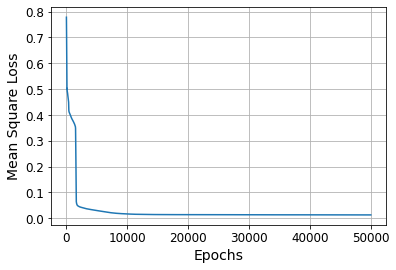

In [ ]:
latent_values = optimize_coding(real_coding, weight_pca)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight_pca).numpy())
# print('Loss: ', mse_loss(generator(latent_values)[:, ntimes:,:,:], real_coding, weight_pca).numpy())
print(latent_values)

In [ ]:
gen_out = generator(latent_values, training=False)
print(gen_out.shape)
gen = gen_out[0].numpy().reshape(9, 50)

GAN_inverse = scaler_minmax.inverse_transform(gen)#.reshape(gen.shape[0]*4, int(gen.shape[1]/4))
print(GAN_inverse.shape)
split_inv = np.split(GAN_inverse, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)


 
X_recovered = pca.inverse_transform(alpha)
print(X_recovered.shape)
# X_unscaled = []
# for i in range(9):
#   X_unscaled.append(scaler_std.inverse_transform(X_recovered[4*i, ].reshape(1, -1)))
#   X_unscaled.append(scaler_x.inverse_transform(X_recovered[4*i + 1, ].reshape(1, -1)))
#   X_unscaled.append(scaler_y.inverse_transform(X_recovered[4*i + 2, ].reshape(1, -1)))
#   X_unscaled.append(scaler_z.inverse_transform(X_recovered[4*i + 3, ].reshape(1, -1)))

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(1, 9, 50, 1)
(9, 50)
(9, 43)
GAN shape output of sensor CO2:  (9, 7)
(9, 595624)
norm_co2_ shape:  (9, 148906)
norm_z_ shape:  (9, 148906)
norm_sensor_CO2_ shape:  (9, 7)


In [ ]:
print(norm_co2_[0].shape)
print(norm_z_[0].shape)
print(norm_sensor_CO2_[0].shape)
print(norm_co2_.max())
print(norm_co2_.min())

(148906,)
(148906,)
(7,)
1986.2820596119209
184.47584168446798


### CO2 at sensor location 
Depiction of the difference between generated and real data points at sensor locations

In [ ]:
# for i in range(8):
#   print(norm_sensor_CO2_[i,:])

# print("\n")
# for i in range(8):
#   print(CO2_sensor[i,:])
#print(CO2_sensor.shape)
print(CO2_sensor[70:80,4])

[1430.86534293 1430.13243161 1429.24170161 1428.0514819  1426.53724923
 1424.49624266 1422.08162598 1419.0259418  1415.44103357 1411.23756432]


 Graph for each sensor location at time progresses

In [ ]:
# #Generated outputs
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(norm_sensor_CO2_[:9,i], '-o')


In [ ]:
# # Clarence Centre CFD outputs
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# #plt.ylim(300, 1700)
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(CO2_sensor[:9,i-1], '-o', color='#F97306')

In [ ]:
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(norm_sensor_CO2_[:9,i], '-o')
#       ax.flatten()[i].plot(CO2_sensor[:9,i], '-o', color='#F97306')

Graph for each Time level showing each 7 sensor location points

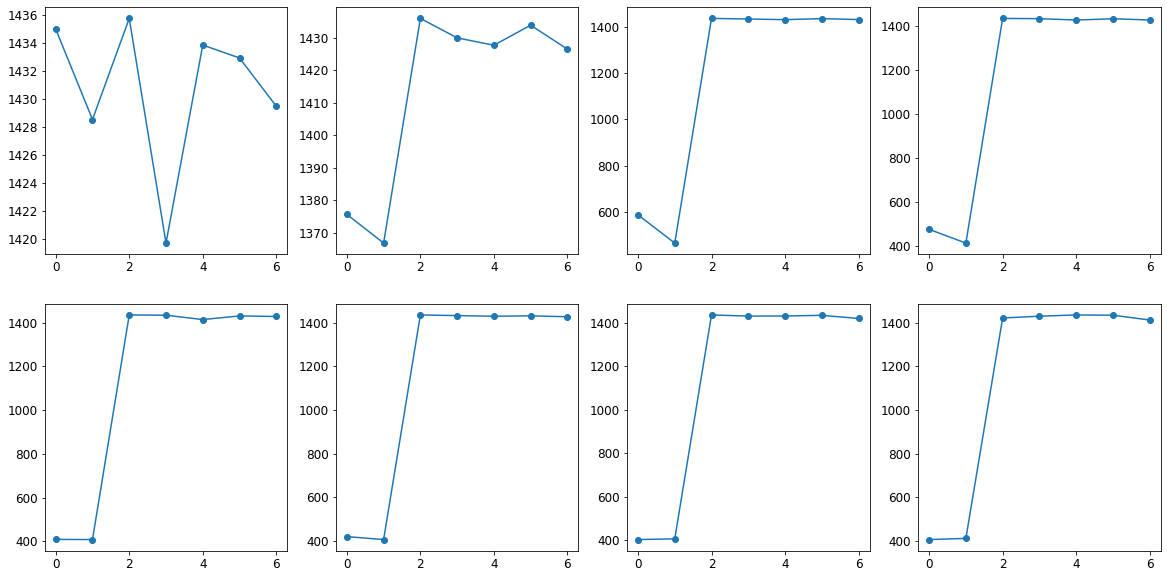

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')

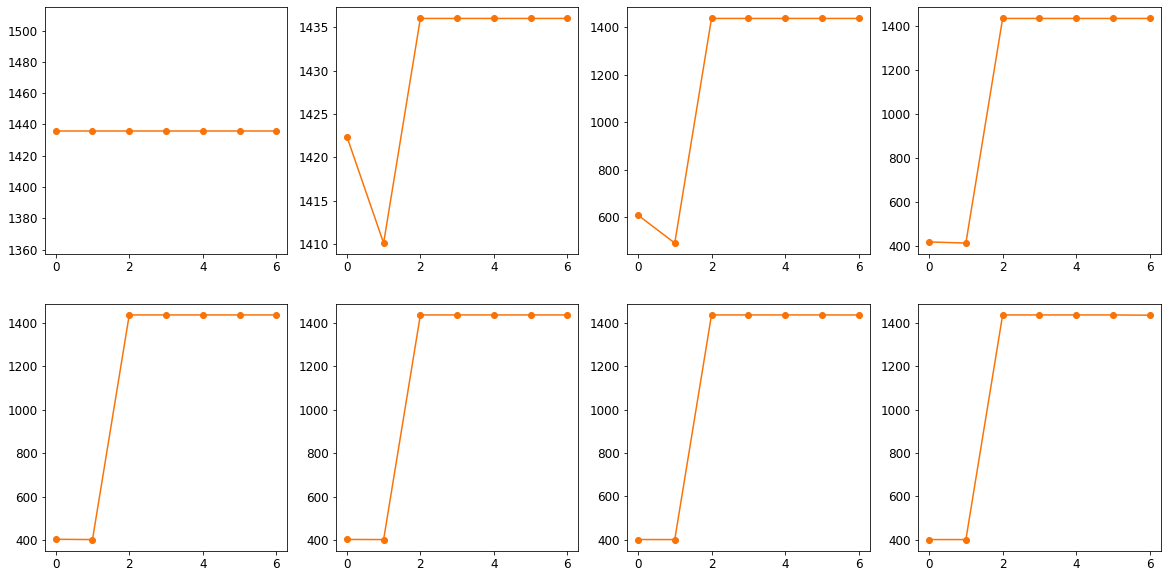

In [ ]:
# Clarence Centre CFD outputs

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o', color='#F97306')

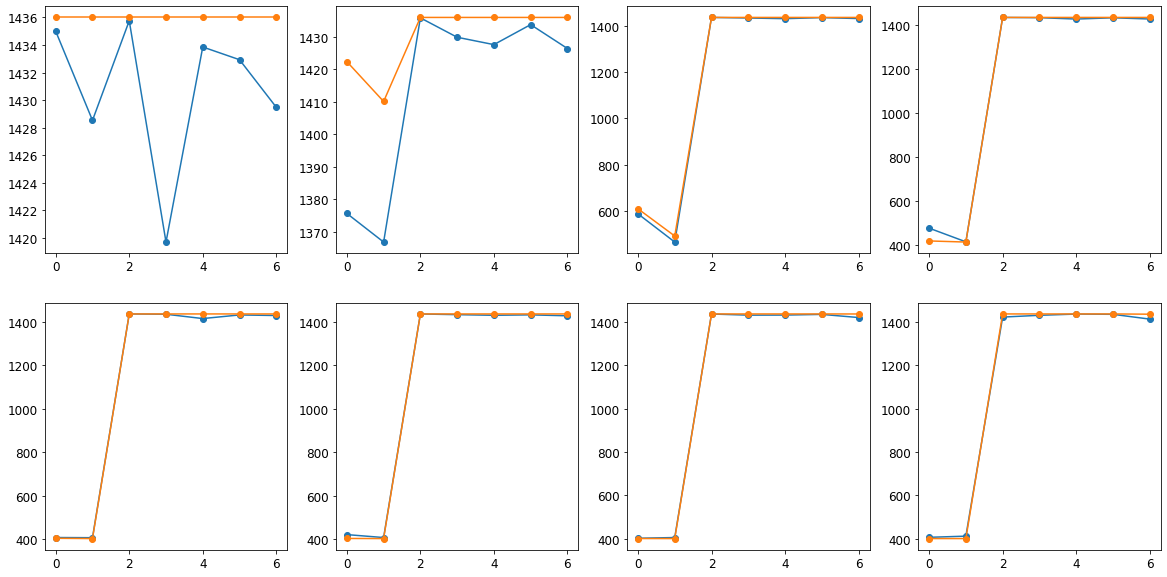

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

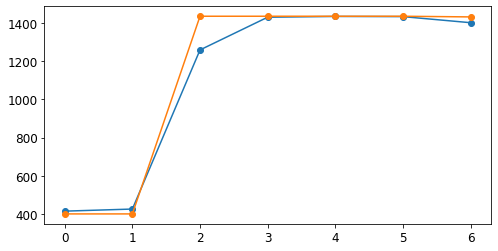

In [ ]:
# Next time level prediction for all sensor locations

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(norm_sensor_CO2_[8,:], '-o')
ax.plot(CO2_sensor[8,:], '-o')

In [ ]:
print(norm_sensor_CO2_[:9, :], "\n")
print(CO2_sensor[:9, :])

[[1414.8221  1416.6205  1398.5692  1429.6697  1435.4497  1435.8026
  1403.6813 ]
 [1373.387   1380.302   1372.2347  1427.5525  1435.5884  1435.9193
  1401.1284 ]
 [ 591.12524  541.9944  1416.1685  1428.9178  1435.4326  1435.9482
  1414.6111 ]
 [ 421.19574  405.62076 1428.4865  1433.604   1435.7279  1435.968
  1420.3977 ]
 [ 413.35617  405.74237 1429.5658  1434.6737  1435.5435  1435.9668
  1415.1594 ]
 [ 432.30728  406.70102 1427.515   1434.9691  1434.8577  1435.9852
  1417.142  ]
 [ 421.00754  402.7965  1427.3905  1434.5417  1434.1737  1435.9866
  1414.5629 ]
 [ 452.92477  406.1854  1401.1625  1433.3787  1434.7898  1435.9014
  1402.2703 ]
 [ 495.34143  415.07367 1391.5015  1432.8558  1433.8354  1435.8044
  1398.5046 ]] 

[[1436.         1436.         1436.         1436.         1436.
  1436.         1436.        ]
 [1422.40820872 1410.14729655 1436.         1436.         1436.
  1436.         1436.        ]
 [ 608.69587777  491.06084034 1436.         1436.         1436.
  1436.        

In [ ]:
# #checks

# print(np.allclose(X_real[7,:], X_real[8,:]))
# print(norm_sensor_CO2_[0,:])
# print(norm_sensor_CO2_[1,:])
# print("\n")
# print(X_real[0,:])
# print(X_real[1,:])

### testing#

In [ ]:
### testing#
import pprint as pprint

nPOD = 10
nVTU = 3
pod_data = np.arange(10,40,1).reshape(nVTU, nPOD)
print("pod_data: ", pod_data)
print(pod_data.shape)

nCO2 = 5
CO2_test = np.arange(100,115,1).reshape(nVTU, nCO2)
print("CO2_test: ", CO2_test)
print(CO2_test.shape)

trial_ = np.concatenate((pod_data, CO2_test), axis=1)
print("concatenated: ", trial_)
print(trial_.shape)

all = np.split(trial_, [nPOD, ], axis=1)
#print(np.shape(all))
print(all[0])

pod_data:  [[10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
(3, 10)
CO2_test:  [[100 101 102 103 104]
 [105 106 107 108 109]
 [110 111 112 113 114]]
(3, 5)
concatenated:  [[ 10  11  12  13  14  15  16  17  18  19 100 101 102 103 104]
 [ 20  21  22  23  24  25  26  27  28  29 105 106 107 108 109]
 [ 30  31  32  33  34  35  36  37  38  39 110 111 112 113 114]]
(3, 15)
[[10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]


In [ ]:
# X = np.array(X_unscaled).reshape(X_recovered.shape[0], X_recovered.shape[1])
# gen_1 = X[0:4]
# gen_2 = X[5:9]
# gen_3 = X[10:14]
# gen_4 = X[15:19]
# gen_5 = X[20:24]
# gen_6 = X[25:29]
# gen_7 = X[30:34]
# gen_8 = X[38:42]
# gen_9 = X[43:47]

In [ ]:
# gen_1[0, :].shape

Writing to VTU file

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/predictions/prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
nVTU = gen_out.shape[1]

In [ ]:
# writing to vtu file
nVTU = gen_out.shape[1] #9
for i in range(nVTU):
  write_example_to_vtu(i)
  print("PredGAN VTU file", i, "written")
print("complete")

PredGAN VTU file 0 written
PredGAN VTU file 1 written
PredGAN VTU file 2 written
PredGAN VTU file 3 written
PredGAN VTU file 4 written
PredGAN VTU file 5 written
PredGAN VTU file 6 written
PredGAN VTU file 7 written
PredGAN VTU file 8 written
complete


In [ ]:
np.allclose(norm_co2_[0], norm_co2_[4])

False